# Conclusion

XGBoost with kfolds=5, sample_weight='balanced', and pruned parameter values found with `RandomizedSearchCV`.

PLAYER_RANKING is not used according to the feature importances.

## HOME_TEAM_WINS

Target to beat - 59.1% home winrate

Achieved - **73% accuracy**

|Pruning|Max Accuracy|Mean Accuracy|Min Accuracy|
|-|-|-|-|
|None|73%|72%|70%|
|max_depth|73%|73%|72%|
|reg_lambda|72%|70%|69%|
|gamma|64%|64%|64%|
|scale_pos_weight|69%|68%|66%|

## HOME_HIGHER_FG_PCT

Target to beat - 55.0% rate of home having higher FGP

Achieved - **62% accuracy**

|Pruning|Max Accuracy|Mean Accuracy|Min Accuracy|
|-|-|-|-|
|None|69%|67%|66%|
|max_depth|70%|68%|67%|
|reg_lambda|68%|66%|64%|
|gamma|62%|60%|58%|
|scale_pos_weight|67%|65%|62%|

## HOME_HIGHER_FG3_PCT

Target to beat - 50.8% rate of home having higher FG3

Achieved - **68% accuracy**

|Pruning|Max Accuracy|Mean Accuracy|Min Accuracy|
|-|-|-|-|
|None|64%|62%|60%|
|max_depth|68%|65%|62%|
|reg_lambda|64%|62%|60%|
|gamma|62%|60%|60%|
|scale_pos_weight|64%|61%|59%|

## HOME_HIGHER_FT_PCT

Target to beat - 49.5% rate of home having higher FTP

Achieved - **66% accuracy**

|Pruning|Max Accuracy|Mean Accuracy|Min Accuracy|
|-|-|-|-|
|None|62%|61%|59%|
|max_depth|66%|64%|62%|
|reg_lambda|63%|62%|60%|
|gamma|62%|60%|57%|
|scale_pos_weight|60%|59%|58%|

## HOME_HIGHER_AST

Target to beat - 55.0% rate of home having higher AST

Achieved - **69% accuracy**

|Pruning|Max Accuracy|Mean Accuracy|Min Accuracy|
|-|-|-|-|
|None|66%|64%|62%|
|max_depth|69%|67%|65%|
|reg_lambda|66%|64%|62%|
|gamma|61%|59%|57%|
|scale_pos_weight|66%|62%|57%|

## HOME_HIGHER_REB

Target to beat - 53.4% rate of home having higher REB

Achieved - **68% accuracy**

|Pruning|Max Accuracy|Mean Accuracy|Min Accuracy|
|-|-|-|-|
|None|66%|64%|62%|
|max_depth|68%|66%|64%|
|reg_lambda|66%|65%|63%|
|gamma|61%|58%|56%|
|scale_pos_weight|64%|59%|56%|


In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from datasets import data as Local ## Local module to get dataframes

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
games_df, winners_df, greater_fgp_df, greater_fg3_df, greater_ft_df, greater_ast_df, greater_reb_df, cumulative_stats_df, games_details_df, teams_df, players_df, ranking_df = \
    Local.get_all_dataset_dataframes('../../datasets/')

In [4]:
cumulative_player_stats_df = Local.get_cumulative_player_stats_dataframe('../../datasets/')

# Target datasets

- Home has:
    - 59.1% Winrate
    - 55.0% Rate of Higher FGP
    - 50.8% Rate of Higher FG3
    - 49.5% Rate of Higher FTP
    - 55.0% Rate of Higher AST
    - 53.4% Rate of Higher REB

In [5]:
winners_df # Whether the home team won in a game in each row of `games_df`

16157    1
16156    1
16155    1
16154    1
16153    1
        ..
4        0
3        0
2        0
1        1
0        1
Name: HOME_TEAM_WINS, Length: 23520, dtype: int64

In [6]:
winners_df.describe()

count    23520.000000
mean         0.591029
std          0.491654
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_TEAM_WINS, dtype: float64

In [7]:
greater_fgp_df.describe()

count    23520.000000
mean         0.550468
std          0.497457
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_FG_PCT, dtype: float64

In [8]:
greater_fg3_df.describe()

count    23520.000000
mean         0.507993
std          0.499947
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_FG3_PCT, dtype: float64

In [9]:
greater_ft_df.describe()

count    23520.000000
mean         0.494855
std          0.499984
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_FT_PCT, dtype: float64

In [10]:
greater_ast_df.describe()

count    23520.000000
mean         0.550128
std          0.497491
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_AST, dtype: float64

In [11]:
greater_reb_df.describe()

count    23520.000000
mean         0.533886
std          0.498861
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_REB, dtype: float64

# Datasets

In [12]:
games_df

GAME_DATE_EST   GAME_ID  HOME_TEAM_ID  VISITOR_TEAM_ID  SEASON  \
16157    2003-10-05  10300001    1610612762       1610612742    2003   
16156    2003-10-06  10300002    1610612763       1610612749    2003   
16155    2003-10-07  10300009    1610612758       1610612746    2003   
16154    2003-10-07  10300005    1610612757       1610612745    2003   
16153    2003-10-07  10300007    1610612748       1610612755    2003   
...             ...       ...           ...              ...     ...   
4        2020-12-18  12000040    1610612761       1610612748    2020   
3        2020-12-18  12000039    1610612754       1610612755    2020   
2        2020-12-19  12000049    1610612763       1610612737    2020   
1        2020-12-19  12000048    1610612764       1610612765    2020   
0        2020-12-19  12000047    1610612753       1610612766    2020   

       PTS_home  FG_PCT_home  FT_PCT_home  FG3_PCT_home  AST_home  REB_home  \
16157      90.0        0.457        0.735         0.143      23.0      41.0   
16156     105.0        0.494        0.618         0.267      25.0      48.0   
16155     101.0        0.467        0.871         0.444      19.0      39.0   
16154     104.0        0.527        0.657         0.429      22.0      33.0   
16153      86.0        0.352        0.647         0.222      15.0      55.0   
...         ...          ...          ...           ...       ...       ...   
4         105.0        0.380        0.737         0.356      27.0      37.0   
3         107.0        0.371        0.692         0.262      19.0      45.0   
2         116.0        0.400        0.744         0.396      21.0      43.0   
1          99.0        0.427        0.625         0.295      24.0      45.0   
0         120.0        0.433        0.792         0.425      23.0      50.0   

       PTS_away  FG_PCT_away  FT_PCT_away  FG3_PCT_away  AST_away  REB_away  
16157      85.0        0.447        0.500         0.250      20.0      38.0  
16156      94.0        0.427        0.700         0.154      20.0      43.0  
16155      82.0        0.368        0.609         0.364      13.0      50.0  
16154      80.0        0.470        0.667         0.333      10.0      37.0  
16153      79.0        0.329        0.897         0.143       7.0      44.0  
...         ...          ...          ...           ...       ...       ...  
4         117.0        0.534        0.741         0.514      30.0      51.0  
3         113.0        0.533        0.629         0.355      23.0      48.0  
2         117.0        0.422        0.837         0.297      24.0      47.0  
1          96.0        0.402        0.647         0.326      18.0      51.0  
0         117.0        0.444        0.864         0.439      21.0      52.0  

[23520 rows x 17 columns]

In [13]:
cumulative_stats_df

DATE   GAME_ID  SEASON_TYPE  SEASON  GAMES_PLAYED_home  \
0      2003-10-05  10300001            1    2003                  0   
1      2003-10-06  10300002            1    2003                  0   
2      2003-10-07  10300009            1    2003                  0   
3      2003-10-07  10300005            1    2003                  0   
4      2003-10-07  10300007            1    2003                  0   
...           ...       ...          ...     ...                ...   
23515  2020-12-18  12000040            1    2020                  2   
23516  2020-12-18  12000039            1    2020                  2   
23517  2020-12-19  12000049            1    2020                  3   
23518  2020-12-19  12000048            1    2020                  2   
23519  2020-12-19  12000047            1    2020                  3   

       GAMES_PLAYED_away  PPG_total_home  FG_PCT_total_home  \
0                      0        0.000000           0.000000   
1                      0        0.000000           0.000000   
2                      0        0.000000           0.000000   
3                      0        0.000000           0.000000   
4                      0        0.000000           0.000000   
...                  ...             ...                ...   
23515                  1      111.500000           0.443500   
23516                  1      105.000000           0.438000   
23517                  3      119.333333           0.466667   
23518                  3      100.000000           0.415000   
23519                  3      112.666667           0.444333   

       FG3_PCT_total_home  FT_PCT_total_home  APG_total_home  RPG_total_home  \
0                0.000000           0.000000        0.000000        0.000000   
1                0.000000           0.000000        0.000000        0.000000   
2                0.000000           0.000000        0.000000        0.000000   
3                0.000000           0.000000        0.000000        0.000000   
4                0.000000           0.000000        0.000000        0.000000   
...                   ...                ...             ...             ...   
23515            0.353000           0.691000       25.000000       41.500000   
23516            0.383000           0.619000       26.000000       35.500000   
23517            0.329333           0.704667       30.666667       52.666667   
23518            0.321500           0.704500       22.000000       44.500000   
23519            0.305333           0.758000       25.000000       51.333333   

       PPG_total_away  FG_PCT_total_away  FG3_PCT_total_away  \
0            0.000000           0.000000            0.000000   
1            0.000000           0.000000            0.000000   
2            0.000000           0.000000            0.000000   
3            0.000000           0.000000            0.000000   
4            0.000000           0.000000            0.000000   
...               ...                ...                 ...   
23515       92.000000           0.427000            0.283000   
23516      108.000000           0.471000            0.241000   
23517      111.333333           0.392667            0.332333   
23518       93.333333           0.413333            0.333000   
23519      110.666667           0.442333            0.372333   

       FT_PCT_total_away  APG_total_away  RPG_total_away  TEAM_ID_away  \
0               0.000000        0.000000        0.000000  1.610613e+09   
1               0.000000        0.000000        0.000000  1.610613e+09   
2               0.000000        0.000000        0.000000  1.610613e+09   
3               0.000000        0.000000        0.000000  1.610613e+09   
4               0.000000        0.000000        0.000000  1.610613e+09   
...                  ...             ...             ...           ...   
23515           0.818000       26.000000       35.000000  1.610613e+09   
23516           0.750000       23.000000       42.000000  1.610613e+09   
23517  

## Add PCA of Player Stats column

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
cumulative_stats_df.insert(len(cumulative_stats_df.columns), 'PLAYER_RANKING_home', np.nan)
cumulative_stats_df.insert(len(cumulative_stats_df.columns), 'PLAYER_RANKING_away', np.nan)

In [17]:
for i, row in cumulative_stats_df.iterrows():
    home_team_player_stats = cumulative_player_stats_df[
        (cumulative_player_stats_df['GAME_ID']==row['GAME_ID'])&
        (cumulative_player_stats_df['TEAM_ID']==row['TEAM_ID_home'])&
        (cumulative_player_stats_df['GAMES_PLAYED']>0)
    ][['PPG_total','FG_PCT_total','FG3_PCT_total','SPG_total','APG_total','FT_PCT_total','BPG_total','RPG_total']].dropna()
    away_team_player_stats = cumulative_player_stats_df[
        (cumulative_player_stats_df['GAME_ID']==row['GAME_ID'])&
        (cumulative_player_stats_df['TEAM_ID']==row['TEAM_ID_away'])&
        (cumulative_player_stats_df['GAMES_PLAYED']>0)
    ][['PPG_total','FG_PCT_total','FG3_PCT_total','SPG_total','APG_total','FT_PCT_total','BPG_total','RPG_total']].dropna()
    if len(home_team_player_stats)>0:
        pca_1 = PCA(n_components=1)
        reduced_home_team_player_stats = pd.DataFrame(pca_1.fit_transform(home_team_player_stats))
        cumulative_stats_df['PLAYER_RANKING_home'].iat[i] = reduced_home_team_player_stats.mean()
    if len(away_team_player_stats)>0:
        pca_1 = PCA(n_components=1)
        reduced_away_team_player_stats = pd.DataFrame(pca_1.fit_transform(away_team_player_stats))
        cumulative_stats_df['PLAYER_RANKING_away'].iat[i] = reduced_away_team_player_stats.mean()
    if i%5000==0:
        print(i)

0
5000
10000
15000
20000


In [18]:
cumulative_stats_df

DATE   GAME_ID  SEASON_TYPE  SEASON  GAMES_PLAYED_home  \
0      2003-10-05  10300001            1    2003                  0   
1      2003-10-06  10300002            1    2003                  0   
2      2003-10-07  10300009            1    2003                  0   
3      2003-10-07  10300005            1    2003                  0   
4      2003-10-07  10300007            1    2003                  0   
...           ...       ...          ...     ...                ...   
23515  2020-12-18  12000040            1    2020                  2   
23516  2020-12-18  12000039            1    2020                  2   
23517  2020-12-19  12000049            1    2020                  3   
23518  2020-12-19  12000048            1    2020                  2   
23519  2020-12-19  12000047            1    2020                  3   

       GAMES_PLAYED_away  PPG_total_home  FG_PCT_total_home  \
0                      0        0.000000           0.000000   
1                      0        0.000000           0.000000   
2                      0        0.000000           0.000000   
3                      0        0.000000           0.000000   
4                      0        0.000000           0.000000   
...                  ...             ...                ...   
23515                  1      111.500000           0.443500   
23516                  1      105.000000           0.438000   
23517                  3      119.333333           0.466667   
23518                  3      100.000000           0.415000   
23519                  3      112.666667           0.444333   

       FG3_PCT_total_home  FT_PCT_total_home  APG_total_home  RPG_total_home  \
0                0.000000           0.000000        0.000000        0.000000   
1                0.000000           0.000000        0.000000        0.000000   
2                0.000000           0.000000        0.000000        0.000000   
3                0.000000           0.000000        0.000000        0.000000   
4                0.000000           0.000000        0.000000        0.000000   
...                   ...                ...             ...             ...   
23515            0.353000           0.691000       25.000000       41.500000   
23516            0.383000           0.619000       26.000000       35.500000   
23517            0.329333           0.704667       30.666667       52.666667   
23518            0.321500           0.704500       22.000000       44.500000   
23519            0.305333           0.758000       25.000000       51.333333   

       PPG_total_away  FG_PCT_total_away  FG3_PCT_total_away  \
0            0.000000           0.000000            0.000000   
1            0.000000           0.000000            0.000000   
2            0.000000           0.000000            0.000000   
3            0.000000           0.000000            0.000000   
4            0.000000           0.000000            0.000000   
...               ...                ...                 ...   
23515       92.000000           0.427000            0.283000   
23516      108.000000           0.471000            0.241000   
23517      111.333333           0.392667            0.332333   
23518       93.333333           0.413333            0.333000   
23519      110.666667           0.442333            0.372333   

       FT_PCT_total_away  APG_total_away  RPG_total_away  TEAM_ID_away  \
0               0.000000        0.000000        0.000000  1.610613e+09   
1               0.000000        0.000000        0.000000  1.610613e+09   
2               0.000000        0.000000        0.000000  1.610613e+09   
3               0.000000        0.000000        0.000000  1.610613e+09   
4               0.000000        0.000000        0.000000  1.610613e+09   
...                  ...             ...             ...           ...   
23515           0.818000       26.000000       35.000000  1.610613e+09   
23516           0.750000       23.000000       42.000000  1.610613e+09   
23517  

## Attach target columns to dataset

In [19]:
cumulative_stats_copy_df = cumulative_stats_df.copy()
cumulative_stats_copy_df['home_win'] = winners_df
cumulative_stats_copy_df['greater_fgp'] = greater_fgp_df
cumulative_stats_copy_df['greater_fg3'] = greater_fg3_df
cumulative_stats_copy_df['greater_ft'] = greater_ft_df
cumulative_stats_copy_df['greater_ast'] = greater_ast_df
cumulative_stats_copy_df['greater_reb'] = greater_reb_df

## Remove rows w/o data

In [20]:
cumulative_stats_copy_df = cumulative_stats_copy_df[(cumulative_stats_copy_df['GAMES_PLAYED_home']>0) & (cumulative_stats_copy_df['GAMES_PLAYED_away']>0)].dropna()

# Get new target datasets after row removal
winners_df = cumulative_stats_copy_df['home_win']
greater_fgp_df = cumulative_stats_copy_df['greater_fgp']
greater_fg3_df = cumulative_stats_copy_df['greater_fg3']
greater_ft_df = cumulative_stats_copy_df['greater_ft']
greater_ast_df = cumulative_stats_copy_df['greater_ast']
greater_reb_df = cumulative_stats_copy_df['greater_reb']

## Remove non-data

In [21]:
# Delete non-data
for key in [
    'DATE','GAME_ID','TEAM_ID_home','TEAM_ID_away','SEASON_TYPE','SEASON','GAMES_PLAYED_home','GAMES_PLAYED_away',
    'home_win','greater_fgp','greater_fg3','greater_ft','greater_ast','greater_reb'
]:
    del cumulative_stats_copy_df[key]
# Only look at home teams
# cumulative_stats_copy_df = cumulative_stats_copy_df.loc[cumulative_stats_copy_df['AT_HOME']==True]
# del cumulative_stats_copy_df['AT_HOME']
cumulative_stats_copy_df

PPG_total_home  FG_PCT_total_home  FG3_PCT_total_home  \
114         79.000000           0.329000            0.143000   
117        100.000000           0.442000            0.365000   
118         90.000000           0.457000            0.143000   
119        105.000000           0.527000            0.700000   
120         76.000000           0.383000            0.200000   
...               ...                ...                 ...   
23515      111.500000           0.443500            0.353000   
23516      105.000000           0.438000            0.383000   
23517      119.333333           0.466667            0.329333   
23518      100.000000           0.415000            0.321500   
23519      112.666667           0.444333            0.305333   

       FT_PCT_total_home  APG_total_home  RPG_total_home  PPG_total_away  \
114             0.897000        7.000000       44.000000       86.000000   
117             0.650000       20.500000       38.500000       62.000000   
118             0.735000       23.000000       41.000000      104.000000   
119             0.714000       27.000000       39.000000       80.000000   
120             0.750000       17.000000       39.000000      101.000000   
...                  ...             ...             ...             ...   
23515           0.691000       25.000000       41.500000       92.000000   
23516           0.619000       26.000000       35.500000      108.000000   
23517           0.704667       30.666667       52.666667      111.333333   
23518           0.704500       22.000000       44.500000       93.333333   
23519           0.758000       25.000000       51.333333      110.666667   

       FG_PCT_total_away  FG3_PCT_total_away  FT_PCT_total_away  \
114             0.352000            0.222000           0.647000   
117             0.385000            0.300000           0.576000   
118             0.527000            0.429000           0.657000   
119             0.350000            0.429000           0.750000   
120             0.464000            0.250000           0.679000   
...                  ...                 ...                ...   
23515           0.427000            0.283000           0.818000   
23516           0.471000            0.241000           0.750000   
23517           0.392667            0.332333           0.789667   
23518           0.413333            0.333000           0.713000   
23519           0.442333            0.372333           0.751000   

       APG_total_away  RPG_total_away  W_PCT_away  W_PCT_home  \
114         15.000000       55.000000    1.000000    0.000000   
117         11.000000       30.000000    1.000000    0.500000   
118         22.000000       33.000000    1.000000    1.000000   
119         18.000000       45.000000    0.000000    1.000000   
120         22.000000       47.000000    1.000000    1.000000   
...               ...             ...         ...         ...   
23515       26.000000       35.000000    0.000000    1.000000   
23516       23.000000       42.000000    1.000000    0.000000   
23517       24.000000       56.000000    0.333333    1.000000   
23518       20.000000       41.666667    0.666667    0.000000   
23519       29.666667       45.000000    0.333333    0.333333   

       PLAYER_RANKING_home  PLAYER_RANKING_away  
114           8.881784e-17         7.894919e-16  
117           1.233581e-16         0.000000e+00  
118          -7.401487e-17         9.128500e-16  
119           4.934325e-16         0.000000e+00  
120          -8.074349e-17        -8.881784e-17  
...                    ...                  ...  
23515         4.934325e-16         4.743680e-16  
23516        -5.736152e-16         5.551115e-17  
23517         1.268826e-16        -9.621933e-16  
23518        -5.181041e-16         4.440892e-16  
23519        -9.083643e-16         8.074349e-17  

[23085 rows x 16 columns]

## Do hyperparameters searches

In [22]:
from sklearn.metrics import classification_report

In [23]:
from sklearn.tree import plot_tree
from yellowbrick.model_selection import FeatureImportances

In [24]:
from sklearn.utils.class_weight import compute_sample_weight

In [25]:
# Get best params based from CV function
def do_cv(classifier, cv_fun, params, x, y, **kwargs):
    clf = cv_fun(
        classifier,
        params,
        scoring='accuracy', # Optimize for the 'accuracy' score of the model.
        **kwargs,
    )
#     clf.fit(x, y, sample_weight=compute_sample_weight('balanced',y))
    clf.fit(x, y)
    return clf

## Plot feature importances

In [26]:
def plot_feature_importances(clf, X, y):
    viz = FeatureImportances(clf, labels=X.columns)
    viz.fit(X, y)
    viz.show()

In [27]:
def print_all_metrics_and_plot(clf, X_train_dict, X_test_dict, y_train_dict, y_test_dict, grid_cv_params):
    scores = []
    for key in X_train_dict.keys():
        cv_clf = do_cv(
            clf,
#             GridSearchCV,
            RandomizedSearchCV,
            grid_cv_params,
            X_train_dict[key],
            y_train_dict[key],
        )
        print(key.upper()+':\n')
        score = cv_clf.best_estimator_.score(X_test_dict[key], y_test_dict[key])
        scores.append(score)
        print('Best XGBoost accuracy (%s): %.2f' % (str(cv_clf.best_params_), score))
        print(classification_report(y_test_dict[key], cv_clf.best_estimator_.predict(X_test_dict[key])))
        plot_feature_importances(cv_clf.best_estimator_, X_train_dict[key], y_train_dict[key])
        print('---------------------------------------------')
    return scores

## Build K-folds datasets

In [28]:
from imblearn.combine import SMOTEENN

In [29]:
from sklearn.model_selection import KFold
kf = KFold(shuffle=True, random_state=123)

X_train_dicts = []
X_test_dicts = []
y_train_dicts = []
y_test_dicts = []

for target, key in [(winners_df, 'winner'), (greater_fgp_df, 'fgp'), (greater_fg3_df, 'fg3'), (greater_ft_df, 'ft'), (greater_ast_df, 'ast'), (greater_reb_df, 'reb')]:
    X_over, y_over = SMOTEENN(sampling_strategy='all').fit_resample(cumulative_stats_copy_df, target)
    for train, test in kf.split(X_over, y_over):
        X_train_dict = {}
        X_test_dict = {}
        y_train_dict = {}
        y_test_dict = {}
        
        X_train_dict[key], X_test_dict[key] = X_over.iloc[train], X_over.iloc[test]
        y_train_dict[key], y_test_dict[key] = y_over.iloc[train], y_over.iloc[test]
        
        X_train_dicts.append(X_train_dict)
        X_test_dicts.append(X_test_dict)
        y_train_dicts.append(y_train_dict)
        y_test_dicts.append(y_test_dict)

assert len(X_train_dicts)==len(X_test_dicts)==len(y_train_dicts)==len(y_test_dicts)
print(len(X_train_dicts))

30


In [30]:
def print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, params):
    scores=[]
    for i in range(len(X_train_dicts)):
        print(f'i={i}')
        score = print_all_metrics_and_plot(
            xgb.XGBClassifier(random_state=0,eval_metric='logloss'),
            X_train_dicts[i],
            X_test_dicts[i],
            y_train_dicts[i],
            y_test_dicts[i],
            params,
        )
        if (i+1)%5==0:
            scores = pd.DataFrame(np.array(scores))
            print(f'Mean accuracy: {scores.mean()[0]}')
            print(f'Max accuracy: {scores.max()[0]}')
            print(f'Min accuracy: {scores.min()[0]}')
            print('=========================================')
            scores=[]
        else:
            scores += score

## Train w/o pruning

In [31]:
import warnings
warnings.filterwarnings("ignore")

i=0
WINNER:

Best XGBoost accuracy ({}): 0.73
              precision    recall  f1-score   support

           0       0.74      0.88      0.80       858
           1       0.71      0.49      0.58       518

    accuracy                           0.73      1376
   macro avg       0.73      0.69      0.69      1376
weighted avg       0.73      0.73      0.72      1376



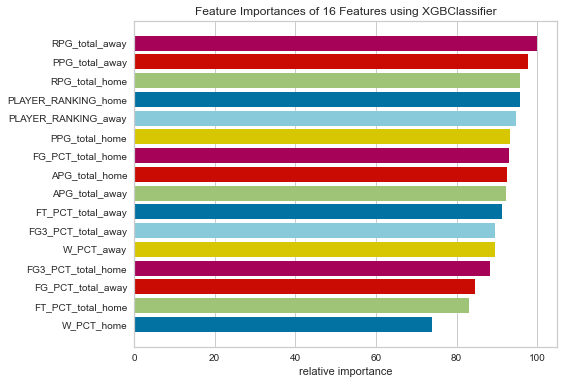

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({}): 0.73
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       880
           1       0.70      0.46      0.55       496

    accuracy                           0.73      1376
   macro avg       0.72      0.67      0.68      1376
weighted avg       0.73      0.73      0.72      1376



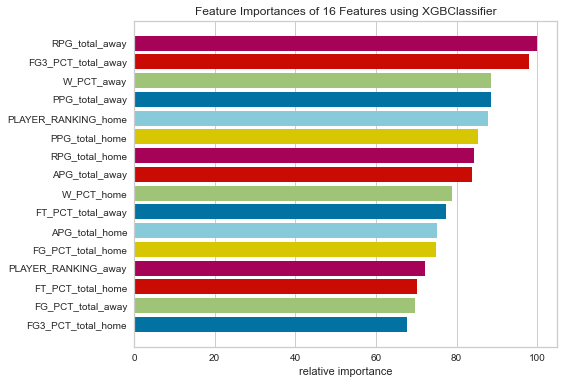

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({}): 0.72
              precision    recall  f1-score   support

           0       0.74      0.86      0.80       874
           1       0.66      0.47      0.55       502

    accuracy                           0.72      1376
   macro avg       0.70      0.67      0.67      1376
weighted avg       0.71      0.72      0.71      1376



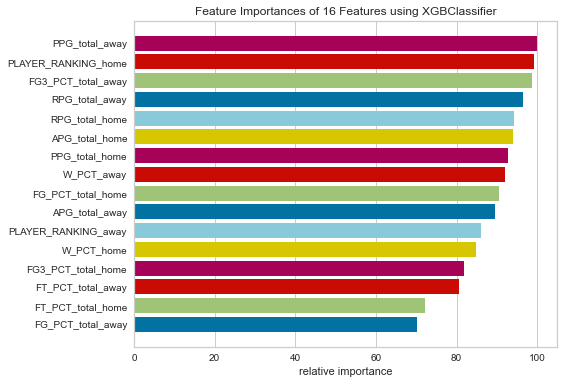

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({}): 0.70
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       868
           1       0.63      0.48      0.55       508

    accuracy                           0.70      1376
   macro avg       0.68      0.66      0.66      1376
weighted avg       0.69      0.70      0.69      1376



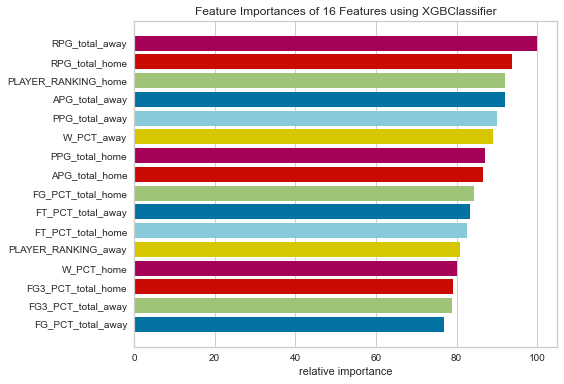

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({}): 0.71
              precision    recall  f1-score   support

           0       0.73      0.86      0.79       878
           1       0.64      0.44      0.52       498

    accuracy                           0.71      1376
   macro avg       0.68      0.65      0.66      1376
weighted avg       0.70      0.71      0.69      1376



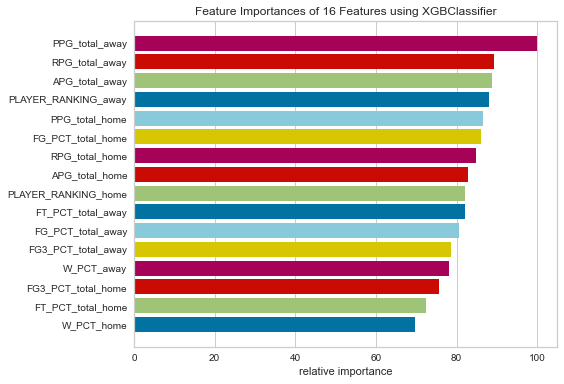

---------------------------------------------
Mean accuracy: 0.7225654069767441
Max accuracy: 0.7340116279069767
Min accuracy: 0.7034883720930233
i=5
FGP:

Best XGBoost accuracy ({}): 0.67
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       602
           1       0.61      0.45      0.52       385

    accuracy                           0.67       987
   macro avg       0.65      0.63      0.63       987
weighted avg       0.66      0.67      0.66       987



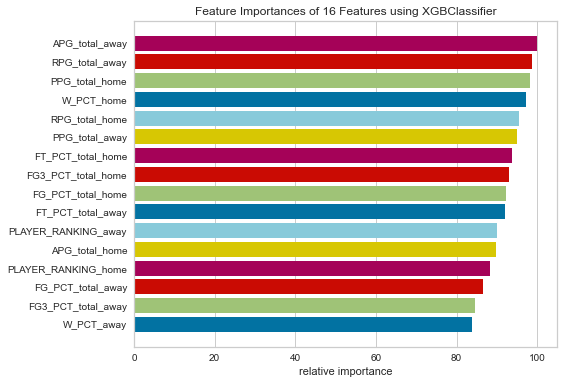

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({}): 0.68
              precision    recall  f1-score   support

           0       0.70      0.82      0.76       595
           1       0.63      0.46      0.53       391

    accuracy                           0.68       986
   macro avg       0.66      0.64      0.64       986
weighted avg       0.67      0.68      0.67       986



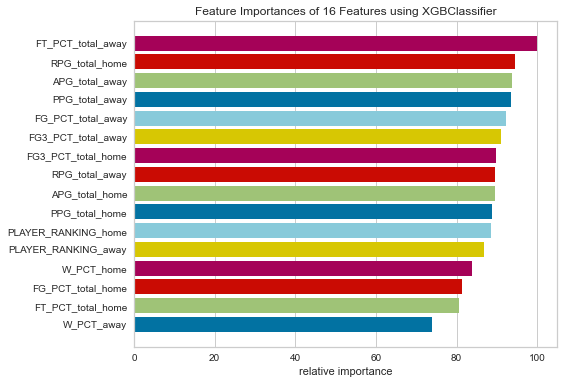

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({}): 0.67
              precision    recall  f1-score   support

           0       0.68      0.81      0.74       574
           1       0.64      0.46      0.54       412

    accuracy                           0.67       986
   macro avg       0.66      0.64      0.64       986
weighted avg       0.66      0.67      0.65       986



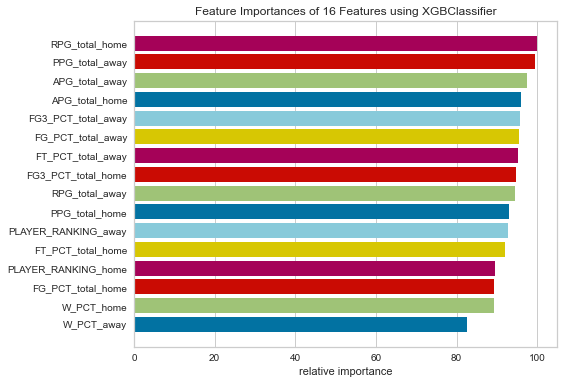

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({}): 0.69
              precision    recall  f1-score   support

           0       0.73      0.81      0.77       612
           1       0.62      0.50      0.55       374

    accuracy                           0.69       986
   macro avg       0.67      0.66      0.66       986
weighted avg       0.69      0.69      0.69       986



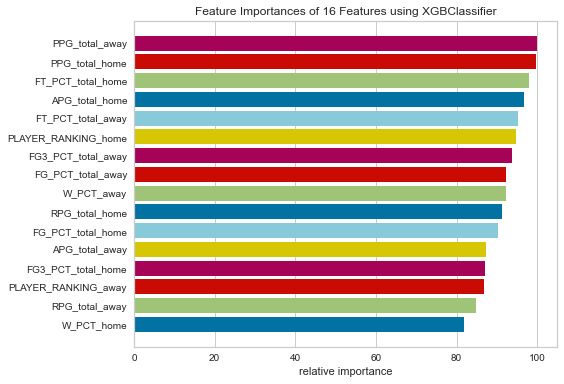

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({}): 0.64
              precision    recall  f1-score   support

           0       0.66      0.80      0.72       572
           1       0.61      0.42      0.50       414

    accuracy                           0.64       986
   macro avg       0.63      0.61      0.61       986
weighted avg       0.64      0.64      0.63       986



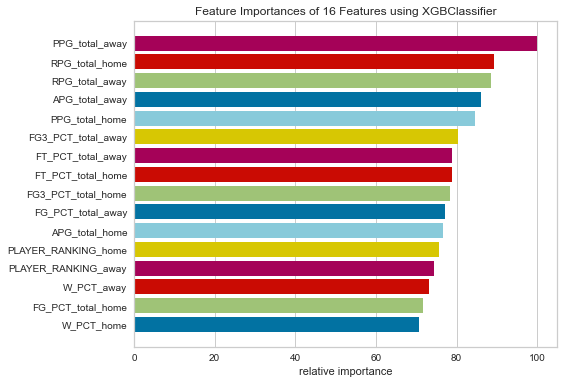

---------------------------------------------
Mean accuracy: 0.6773144694414817
Max accuracy: 0.6937119675456389
Min accuracy: 0.6663286004056795
i=10
FG3:

Best XGBoost accuracy ({}): 0.62
              precision    recall  f1-score   support

           0       0.62      0.68      0.65       325
           1       0.62      0.56      0.59       304

    accuracy                           0.62       629
   macro avg       0.62      0.62      0.62       629
weighted avg       0.62      0.62      0.62       629



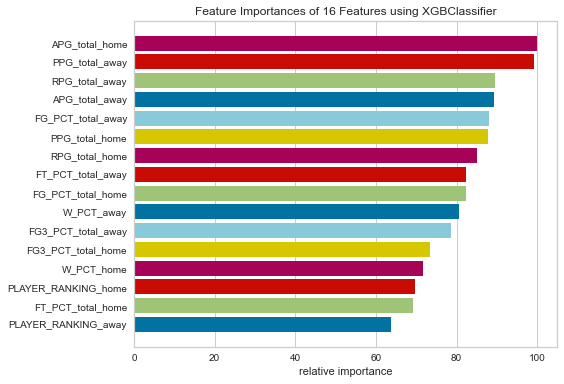

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({}): 0.61
              precision    recall  f1-score   support

           0       0.62      0.63      0.62       326
           1       0.59      0.59      0.59       303

    accuracy                           0.61       629
   macro avg       0.61      0.61      0.61       629
weighted avg       0.61      0.61      0.61       629



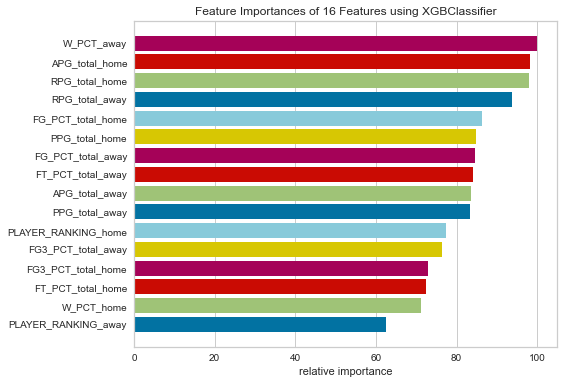

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({}): 0.65
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       345
           1       0.61      0.60      0.60       284

    accuracy                           0.65       629
   macro avg       0.64      0.64      0.64       629
weighted avg       0.64      0.65      0.65       629



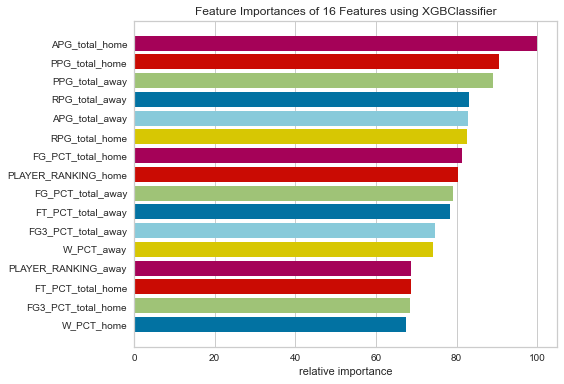

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({}): 0.63
              precision    recall  f1-score   support

           0       0.63      0.68      0.66       325
           1       0.63      0.58      0.60       304

    accuracy                           0.63       629
   macro avg       0.63      0.63      0.63       629
weighted avg       0.63      0.63      0.63       629



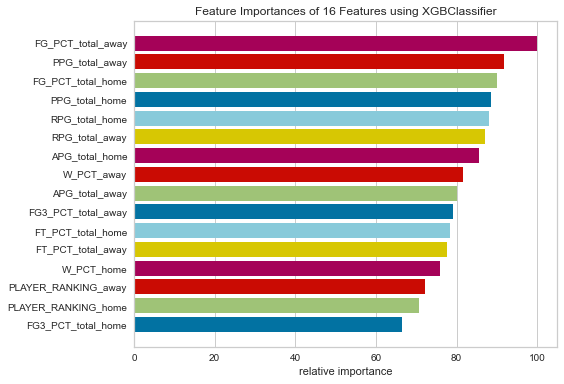

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({}): 0.64
              precision    recall  f1-score   support

           0       0.66      0.64      0.65       332
           1       0.61      0.64      0.62       296

    accuracy                           0.64       628
   macro avg       0.64      0.64      0.64       628
weighted avg       0.64      0.64      0.64       628



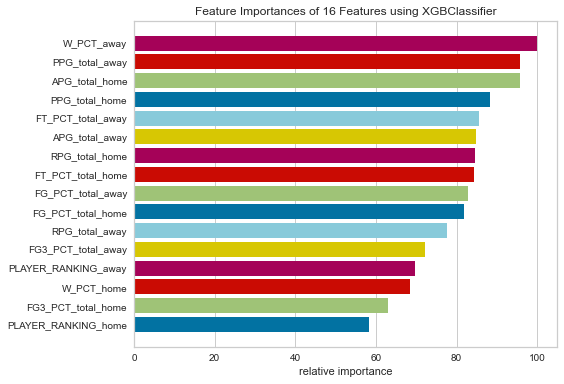

---------------------------------------------
Mean accuracy: 0.6267885532591415
Max accuracy: 0.6454689984101749
Min accuracy: 0.6073131955484896
i=15
FT:

Best XGBoost accuracy ({}): 0.63
              precision    recall  f1-score   support

           0       0.60      0.62      0.61       301
           1       0.65      0.63      0.64       337

    accuracy                           0.63       638
   macro avg       0.63      0.63      0.63       638
weighted avg       0.63      0.63      0.63       638



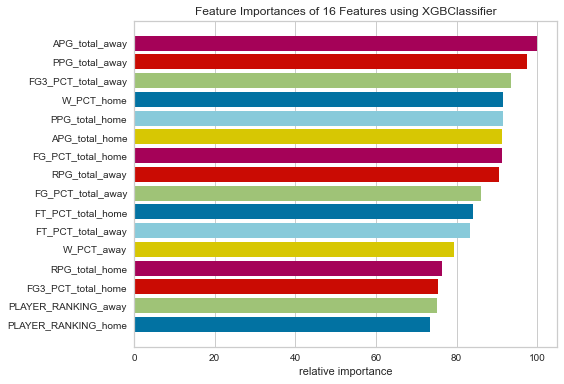

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({}): 0.62
              precision    recall  f1-score   support

           0       0.59      0.59      0.59       301
           1       0.64      0.64      0.64       337

    accuracy                           0.62       638
   macro avg       0.61      0.61      0.61       638
weighted avg       0.62      0.62      0.62       638



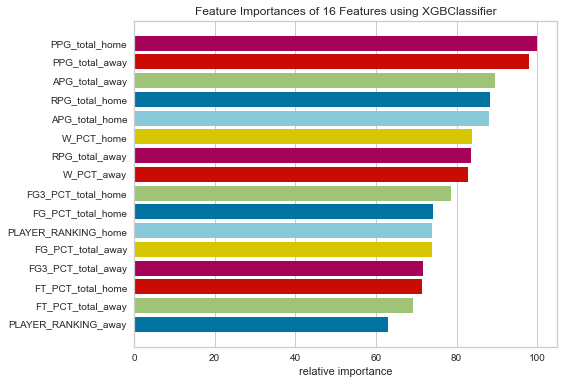

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({}): 0.60
              precision    recall  f1-score   support

           0       0.63      0.57      0.60       334
           1       0.57      0.63      0.60       304

    accuracy                           0.60       638
   macro avg       0.60      0.60      0.60       638
weighted avg       0.60      0.60      0.60       638



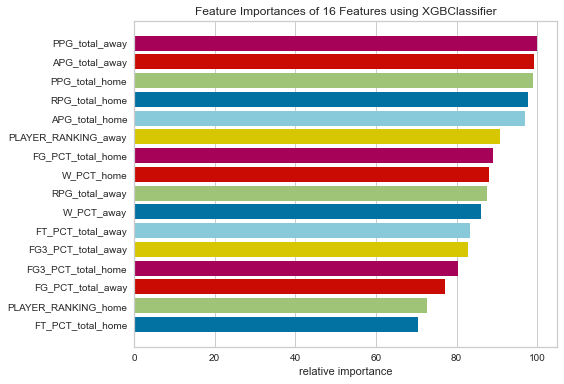

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({}): 0.63
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       298
           1       0.65      0.65      0.65       339

    accuracy                           0.63       637
   macro avg       0.63      0.63      0.63       637
weighted avg       0.63      0.63      0.63       637



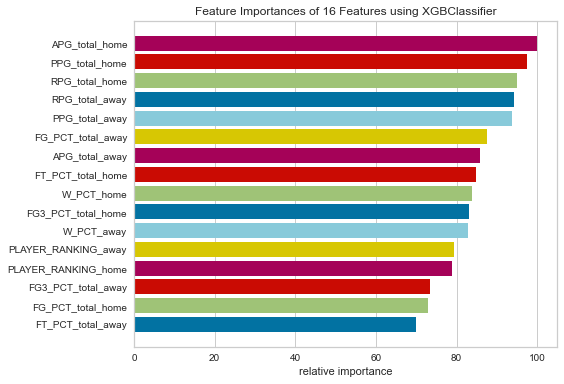

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({}): 0.60
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       314
           1       0.61      0.61      0.61       323

    accuracy                           0.60       637
   macro avg       0.60      0.60      0.60       637
weighted avg       0.60      0.60      0.60       637



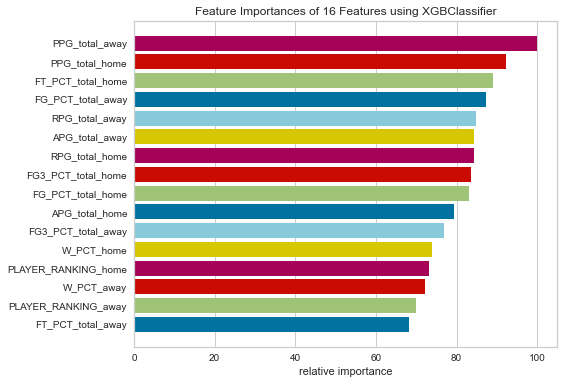

---------------------------------------------
Mean accuracy: 0.6178015334419276
Max accuracy: 0.6295133437990581
Min accuracy: 0.5971786833855799
i=20
AST:

Best XGBoost accuracy ({}): 0.65
              precision    recall  f1-score   support

           0       0.67      0.78      0.72       570
           1       0.60      0.46      0.52       405

    accuracy                           0.65       975
   macro avg       0.63      0.62      0.62       975
weighted avg       0.64      0.65      0.64       975



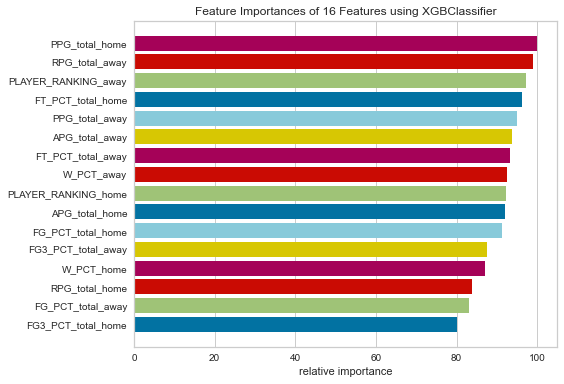

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({}): 0.66
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       592
           1       0.58      0.47      0.52       382

    accuracy                           0.66       974
   macro avg       0.64      0.63      0.63       974
weighted avg       0.65      0.66      0.65       974



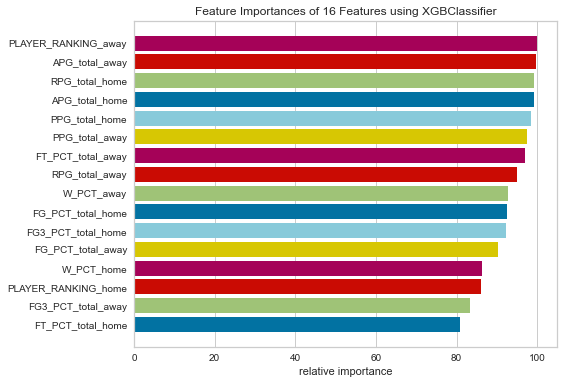

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({}): 0.65
              precision    recall  f1-score   support

           0       0.67      0.77      0.72       561
           1       0.61      0.47      0.53       413

    accuracy                           0.65       974
   macro avg       0.64      0.62      0.62       974
weighted avg       0.64      0.65      0.64       974



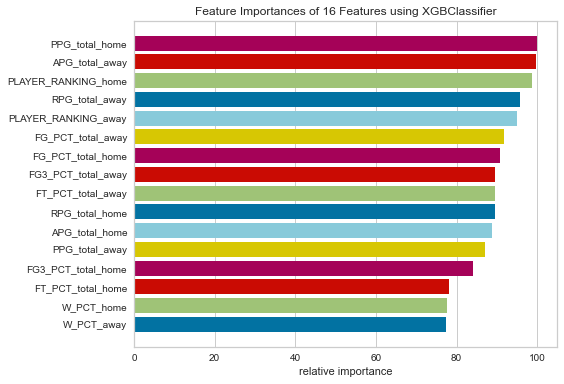

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({}): 0.63
              precision    recall  f1-score   support

           0       0.67      0.76      0.71       596
           1       0.52      0.42      0.46       378

    accuracy                           0.63       974
   macro avg       0.60      0.59      0.59       974
weighted avg       0.61      0.63      0.62       974



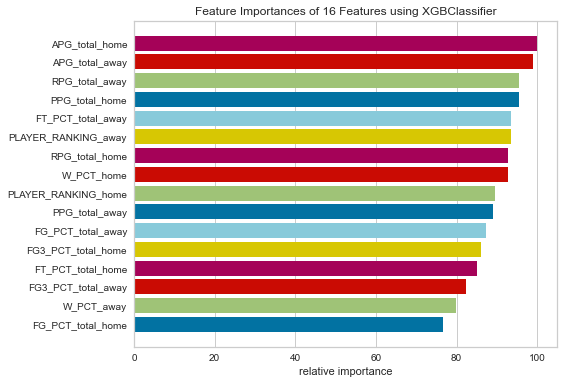

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({}): 0.66
              precision    recall  f1-score   support

           0       0.66      0.84      0.74       564
           1       0.65      0.41      0.50       410

    accuracy                           0.66       974
   macro avg       0.66      0.63      0.62       974
weighted avg       0.66      0.66      0.64       974



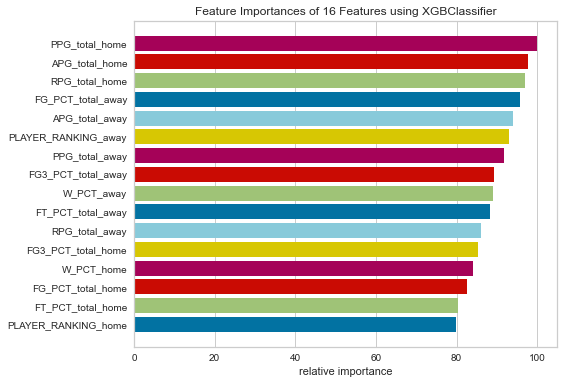

---------------------------------------------
Mean accuracy: 0.6445980097930817
Max accuracy: 0.6611909650924025
Min accuracy: 0.6252566735112937
i=25
REB:

Best XGBoost accuracy ({}): 0.67
              precision    recall  f1-score   support

           0       0.70      0.78      0.73       498
           1       0.61      0.51      0.55       342

    accuracy                           0.67       840
   macro avg       0.65      0.64      0.64       840
weighted avg       0.66      0.67      0.66       840



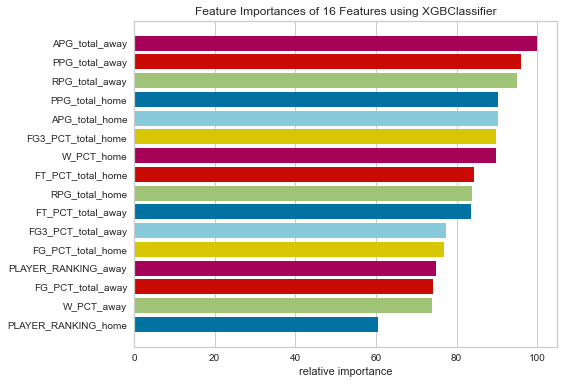

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({}): 0.62
              precision    recall  f1-score   support

           0       0.64      0.75      0.69       471
           1       0.59      0.46      0.52       369

    accuracy                           0.62       840
   macro avg       0.61      0.60      0.60       840
weighted avg       0.62      0.62      0.61       840



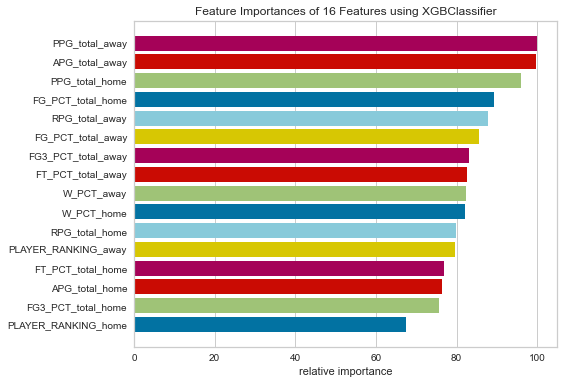

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({}): 0.65
              precision    recall  f1-score   support

           0       0.66      0.78      0.72       473
           1       0.63      0.48      0.54       366

    accuracy                           0.65       839
   macro avg       0.64      0.63      0.63       839
weighted avg       0.65      0.65      0.64       839



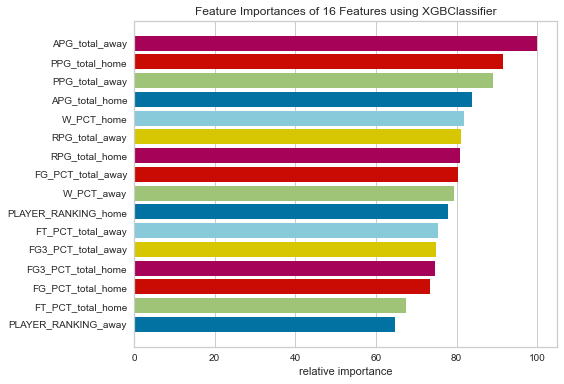

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({}): 0.65
              precision    recall  f1-score   support

           0       0.71      0.74      0.72       516
           1       0.55      0.52      0.53       323

    accuracy                           0.65       839
   macro avg       0.63      0.63      0.63       839
weighted avg       0.65      0.65      0.65       839



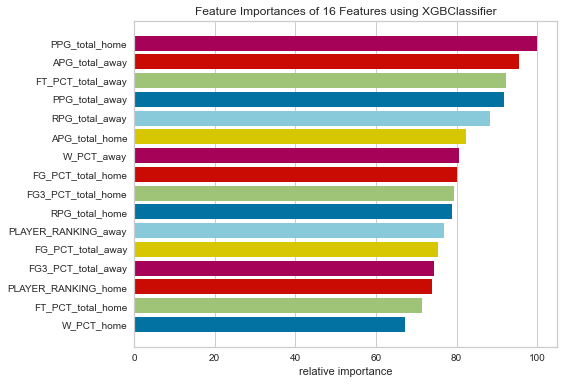

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({}): 0.64
              precision    recall  f1-score   support

           0       0.65      0.77      0.71       465
           1       0.63      0.48      0.54       374

    accuracy                           0.64       839
   macro avg       0.64      0.63      0.62       839
weighted avg       0.64      0.64      0.63       839



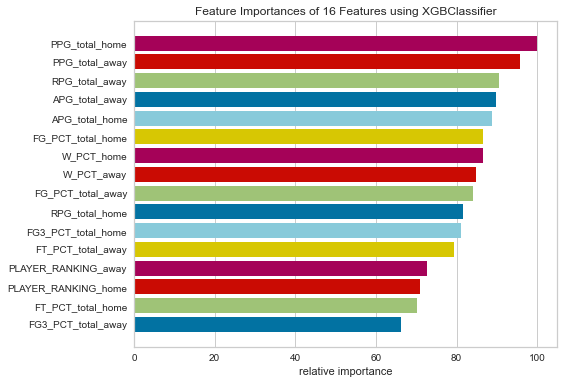

---------------------------------------------
Mean accuracy: 0.6477091492139168
Max accuracy: 0.6654761904761904
Min accuracy: 0.6226190476190476


In [32]:
print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {})

## Try prune max depth

i=0
WINNER:

Best XGBoost accuracy ({'max_depth': 29}): 0.74
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       858
           1       0.73      0.48      0.58       518

    accuracy                           0.74      1376
   macro avg       0.73      0.69      0.69      1376
weighted avg       0.74      0.74      0.72      1376



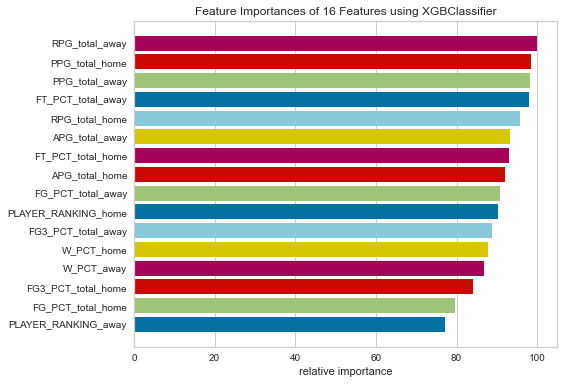

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({'max_depth': 19}): 0.73
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       880
           1       0.69      0.45      0.54       496

    accuracy                           0.73      1376
   macro avg       0.71      0.67      0.67      1376
weighted avg       0.72      0.73      0.71      1376



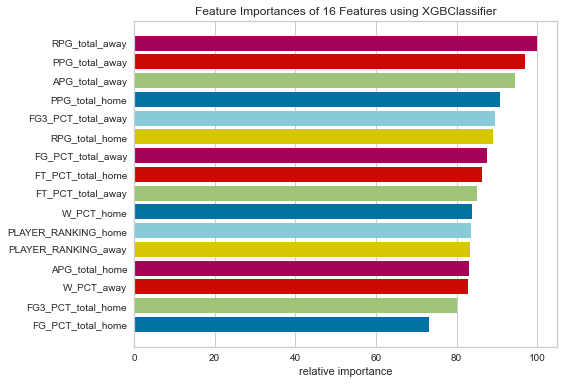

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({'max_depth': 28}): 0.72
              precision    recall  f1-score   support

           0       0.74      0.86      0.80       874
           1       0.66      0.48      0.55       502

    accuracy                           0.72      1376
   macro avg       0.70      0.67      0.68      1376
weighted avg       0.71      0.72      0.71      1376



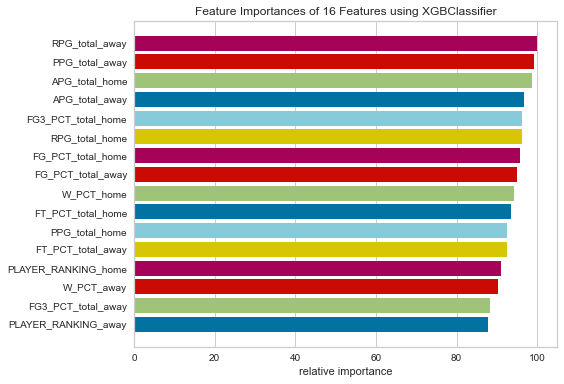

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({'max_depth': 18}): 0.74
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       868
           1       0.70      0.49      0.58       508

    accuracy                           0.74      1376
   macro avg       0.73      0.69      0.69      1376
weighted avg       0.73      0.74      0.72      1376



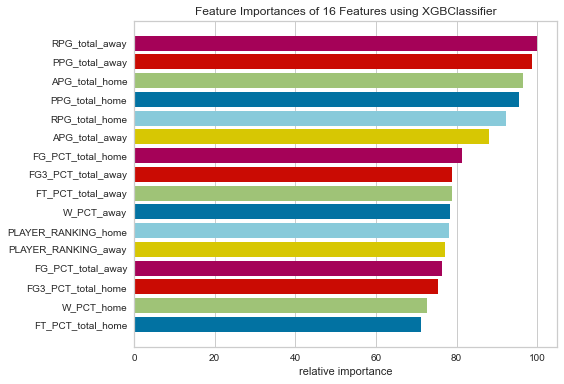

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({'max_depth': 18}): 0.72
              precision    recall  f1-score   support

           0       0.74      0.87      0.80       878
           1       0.67      0.45      0.54       498

    accuracy                           0.72      1376
   macro avg       0.70      0.66      0.67      1376
weighted avg       0.71      0.72      0.70      1376



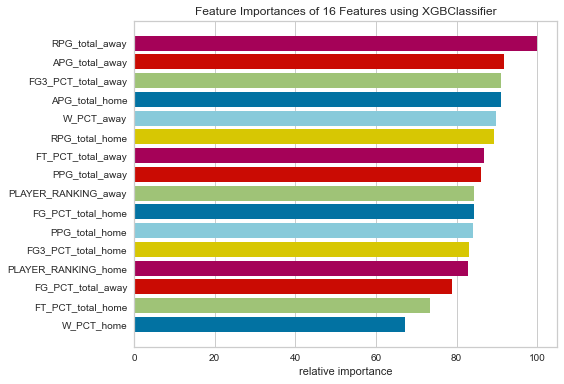

---------------------------------------------
Mean accuracy: 0.7301962209302326
Max accuracy: 0.7369186046511628
Min accuracy: 0.720203488372093
i=5
FGP:

Best XGBoost accuracy ({'max_depth': 13}): 0.69
              precision    recall  f1-score   support

           0       0.71      0.82      0.76       602
           1       0.63      0.49      0.55       385

    accuracy                           0.69       987
   macro avg       0.67      0.65      0.65       987
weighted avg       0.68      0.69      0.68       987



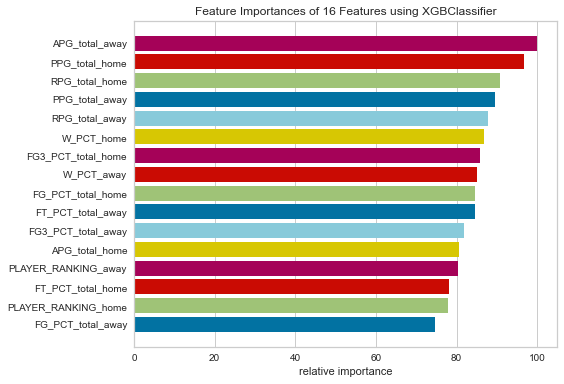

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({'max_depth': 29}): 0.67
              precision    recall  f1-score   support

           0       0.69      0.82      0.75       595
           1       0.62      0.45      0.52       391

    accuracy                           0.67       986
   macro avg       0.66      0.63      0.64       986
weighted avg       0.66      0.67      0.66       986



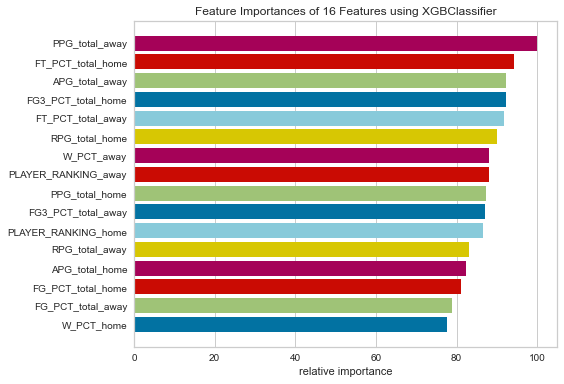

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({'max_depth': 19}): 0.67
              precision    recall  f1-score   support

           0       0.68      0.83      0.75       574
           1       0.66      0.46      0.54       412

    accuracy                           0.67       986
   macro avg       0.67      0.64      0.64       986
weighted avg       0.67      0.67      0.66       986



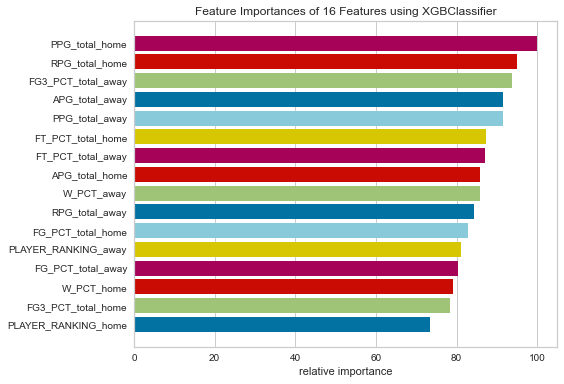

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({'max_depth': 19}): 0.70
              precision    recall  f1-score   support

           0       0.73      0.82      0.78       612
           1       0.64      0.51      0.57       374

    accuracy                           0.70       986
   macro avg       0.68      0.67      0.67       986
weighted avg       0.70      0.70      0.70       986



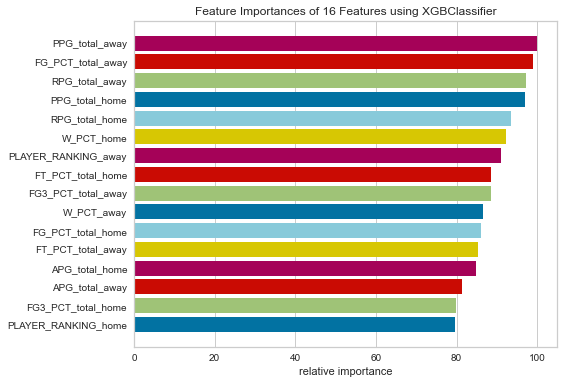

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({'max_depth': 23}): 0.67
              precision    recall  f1-score   support

           0       0.68      0.83      0.75       572
           1       0.66      0.46      0.54       414

    accuracy                           0.67       986
   macro avg       0.67      0.65      0.65       986
weighted avg       0.67      0.67      0.66       986



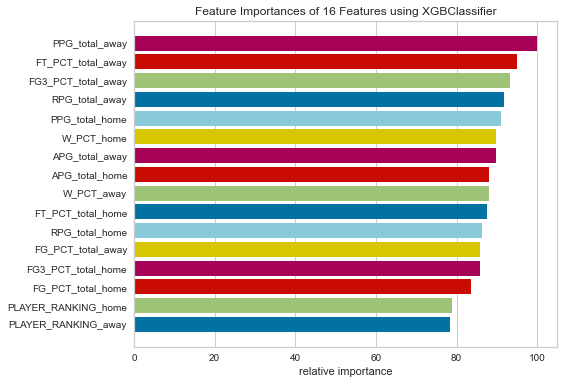

---------------------------------------------
Mean accuracy: 0.6846633003898551
Max accuracy: 0.7038539553752535
Min accuracy: 0.6724137931034483
i=10
FG3:

Best XGBoost accuracy ({'max_depth': 24}): 0.65
              precision    recall  f1-score   support

           0       0.65      0.72      0.68       325
           1       0.66      0.58      0.62       304

    accuracy                           0.65       629
   macro avg       0.65      0.65      0.65       629
weighted avg       0.65      0.65      0.65       629



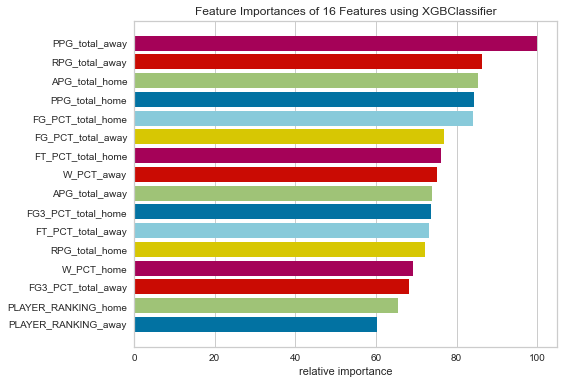

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({'max_depth': 17}): 0.63
              precision    recall  f1-score   support

           0       0.64      0.63      0.64       326
           1       0.61      0.62      0.62       303

    accuracy                           0.63       629
   macro avg       0.63      0.63      0.63       629
weighted avg       0.63      0.63      0.63       629



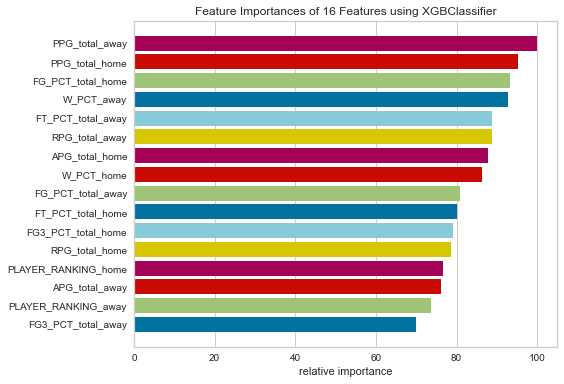

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({'max_depth': 10}): 0.68
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       345
           1       0.65      0.66      0.65       284

    accuracy                           0.68       629
   macro avg       0.68      0.68      0.68       629
weighted avg       0.68      0.68      0.68       629



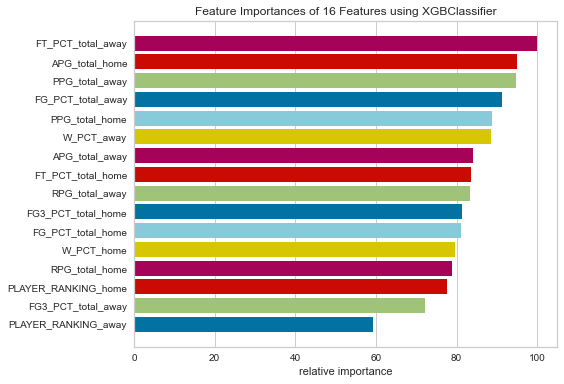

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({'max_depth': 11}): 0.65
              precision    recall  f1-score   support

           0       0.64      0.71      0.67       325
           1       0.65      0.58      0.61       304

    accuracy                           0.65       629
   macro avg       0.65      0.64      0.64       629
weighted avg       0.65      0.65      0.65       629



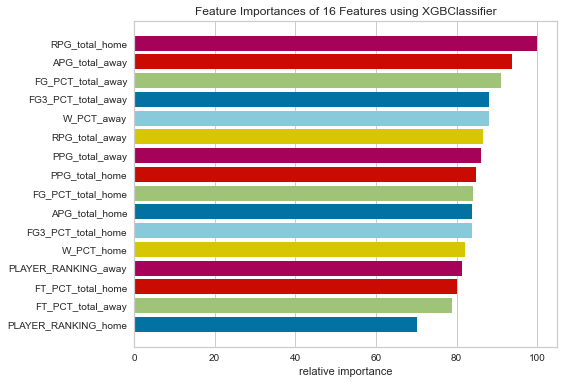

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({'max_depth': 27}): 0.64
              precision    recall  f1-score   support

           0       0.66      0.66      0.66       332
           1       0.62      0.62      0.62       296

    accuracy                           0.64       628
   macro avg       0.64      0.64      0.64       628
weighted avg       0.64      0.64      0.64       628



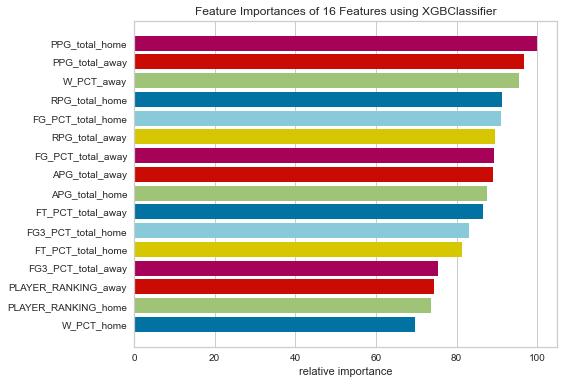

---------------------------------------------
Mean accuracy: 0.6526232114467408
Max accuracy: 0.6836248012718601
Min accuracy: 0.6279809220985691
i=15
FT:

Best XGBoost accuracy ({'max_depth': 18}): 0.66
              precision    recall  f1-score   support

           0       0.63      0.67      0.65       301
           1       0.69      0.65      0.67       337

    accuracy                           0.66       638
   macro avg       0.66      0.66      0.66       638
weighted avg       0.66      0.66      0.66       638



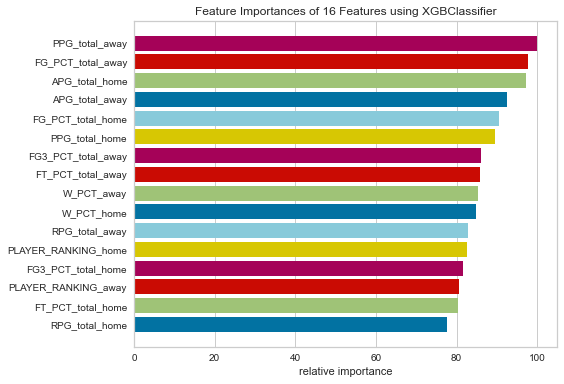

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({'max_depth': 19}): 0.62
              precision    recall  f1-score   support

           0       0.60      0.61      0.61       301
           1       0.65      0.63      0.64       337

    accuracy                           0.62       638
   macro avg       0.62      0.62      0.62       638
weighted avg       0.62      0.62      0.62       638



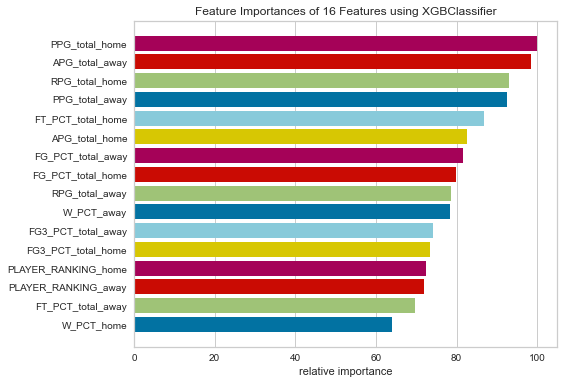

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({'max_depth': 17}): 0.66
              precision    recall  f1-score   support

           0       0.69      0.64      0.66       334
           1       0.63      0.68      0.66       304

    accuracy                           0.66       638
   macro avg       0.66      0.66      0.66       638
weighted avg       0.66      0.66      0.66       638



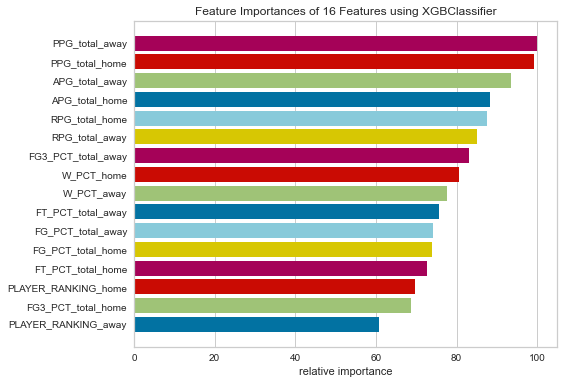

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({'max_depth': 10}): 0.63
              precision    recall  f1-score   support

           0       0.60      0.59      0.60       298
           1       0.65      0.66      0.65       339

    accuracy                           0.63       637
   macro avg       0.62      0.62      0.62       637
weighted avg       0.63      0.63      0.63       637



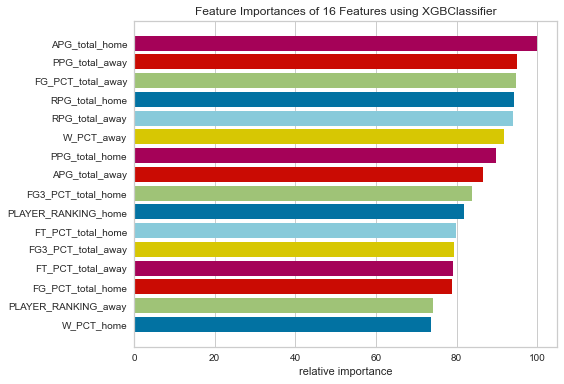

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({'max_depth': 12}): 0.60
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       314
           1       0.61      0.61      0.61       323

    accuracy                           0.60       637
   macro avg       0.60      0.60      0.60       637
weighted avg       0.60      0.60      0.60       637



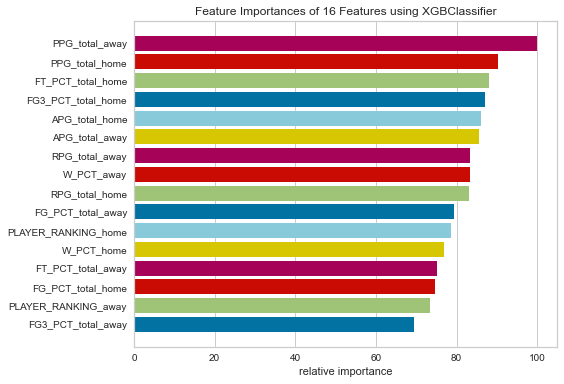

---------------------------------------------
Mean accuracy: 0.6428786730510868
Max accuracy: 0.6614420062695925
Min accuracy: 0.6238244514106583
i=20
AST:

Best XGBoost accuracy ({'max_depth': 24}): 0.69
              precision    recall  f1-score   support

           0       0.70      0.83      0.76       570
           1       0.67      0.50      0.58       405

    accuracy                           0.69       975
   macro avg       0.69      0.66      0.67       975
weighted avg       0.69      0.69      0.68       975



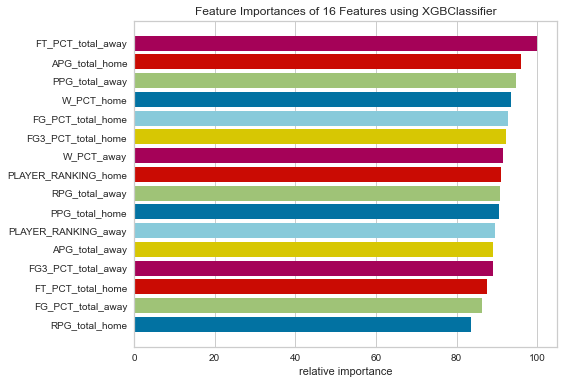

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({'max_depth': 25}): 0.69
              precision    recall  f1-score   support

           0       0.72      0.79      0.76       592
           1       0.62      0.53      0.57       382

    accuracy                           0.69       974
   macro avg       0.67      0.66      0.66       974
weighted avg       0.68      0.69      0.68       974



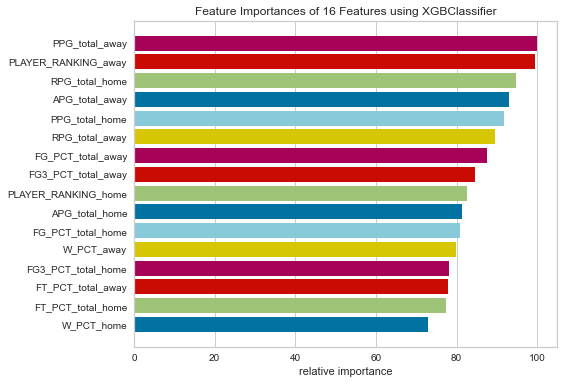

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({'max_depth': 18}): 0.66
              precision    recall  f1-score   support

           0       0.67      0.79      0.73       561
           1       0.62      0.48      0.54       413

    accuracy                           0.66       974
   macro avg       0.65      0.63      0.63       974
weighted avg       0.65      0.66      0.65       974



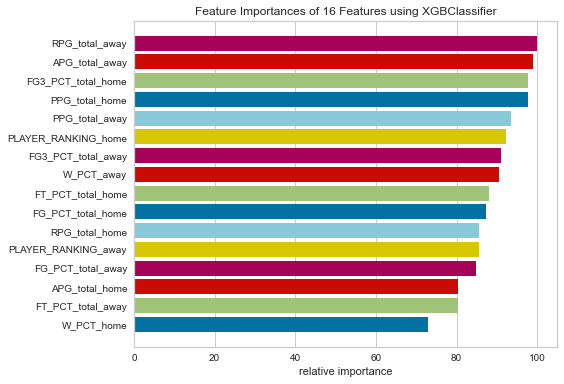

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({'max_depth': 21}): 0.66
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       596
           1       0.58      0.47      0.52       378

    accuracy                           0.66       974
   macro avg       0.64      0.63      0.63       974
weighted avg       0.65      0.66      0.65       974



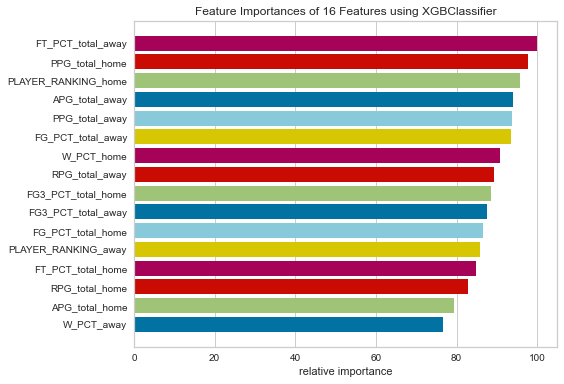

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({'max_depth': 18}): 0.68
              precision    recall  f1-score   support

           0       0.68      0.83      0.75       564
           1       0.67      0.47      0.55       410

    accuracy                           0.68       974
   macro avg       0.68      0.65      0.65       974
weighted avg       0.68      0.68      0.67       974



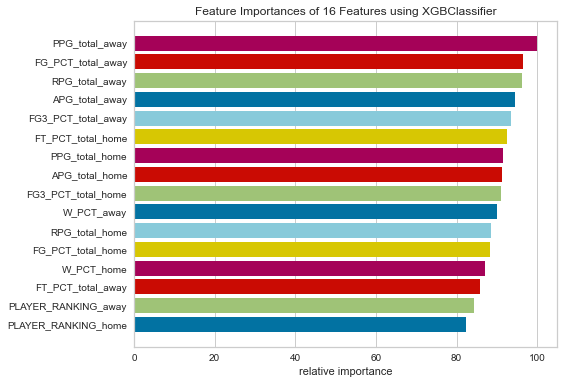

---------------------------------------------
Mean accuracy: 0.6746169641446849
Max accuracy: 0.6923076923076923
Min accuracy: 0.6570841889117043
i=25
REB:

Best XGBoost accuracy ({'max_depth': 8}): 0.66
              precision    recall  f1-score   support

           0       0.68      0.79      0.73       498
           1       0.60      0.47      0.53       342

    accuracy                           0.66       840
   macro avg       0.64      0.63      0.63       840
weighted avg       0.65      0.66      0.65       840



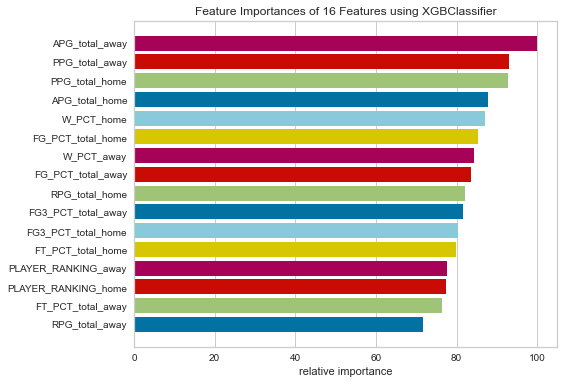

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({'max_depth': 15}): 0.67
              precision    recall  f1-score   support

           0       0.68      0.79      0.73       471
           1       0.66      0.52      0.58       369

    accuracy                           0.67       840
   macro avg       0.67      0.66      0.66       840
weighted avg       0.67      0.67      0.67       840



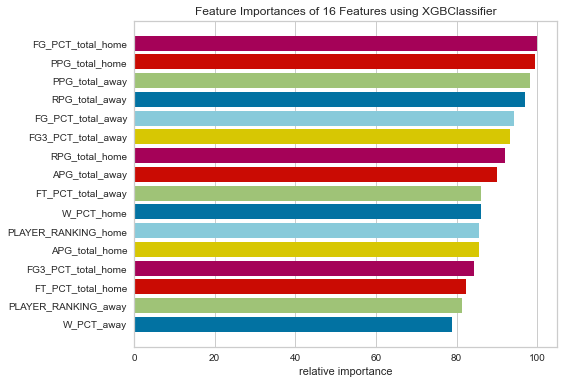

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({'max_depth': 10}): 0.65
              precision    recall  f1-score   support

           0       0.66      0.76      0.71       473
           1       0.62      0.50      0.56       366

    accuracy                           0.65       839
   macro avg       0.64      0.63      0.63       839
weighted avg       0.64      0.65      0.64       839



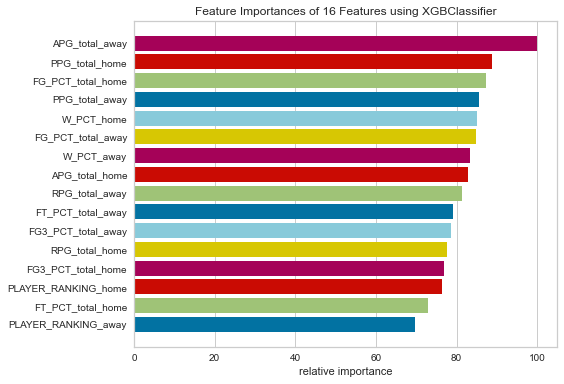

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({'max_depth': 21}): 0.69
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       516
           1       0.60      0.58      0.59       323

    accuracy                           0.69       839
   macro avg       0.67      0.67      0.67       839
weighted avg       0.69      0.69      0.69       839



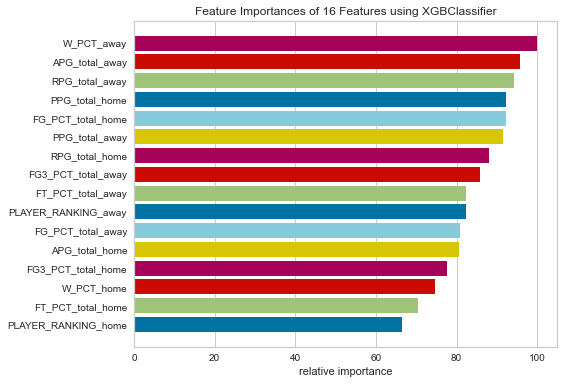

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({'max_depth': 10}): 0.66
              precision    recall  f1-score   support

           0       0.66      0.79      0.72       465
           1       0.66      0.49      0.56       374

    accuracy                           0.66       839
   macro avg       0.66      0.64      0.64       839
weighted avg       0.66      0.66      0.65       839



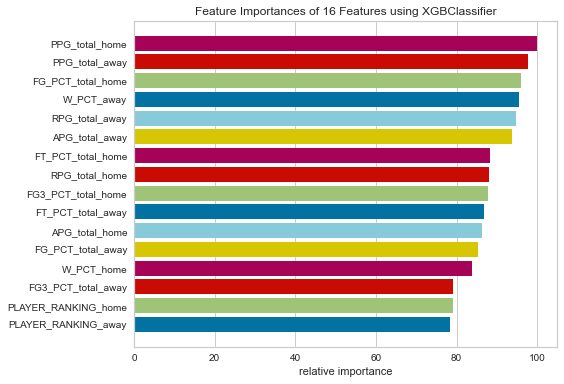

---------------------------------------------
Mean accuracy: 0.6667667007208128
Max accuracy: 0.6877234803337307
Min accuracy: 0.6483909415971395


In [33]:
print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'max_depth': [*range(3,30)],
})

## Try prune reg_lambda

i=0
WINNER:

Best XGBoost accuracy ({'reg_lambda': 0.25}): 0.73
              precision    recall  f1-score   support

           0       0.73      0.88      0.80       858
           1       0.70      0.47      0.56       518

    accuracy                           0.73      1376
   macro avg       0.72      0.67      0.68      1376
weighted avg       0.72      0.73      0.71      1376



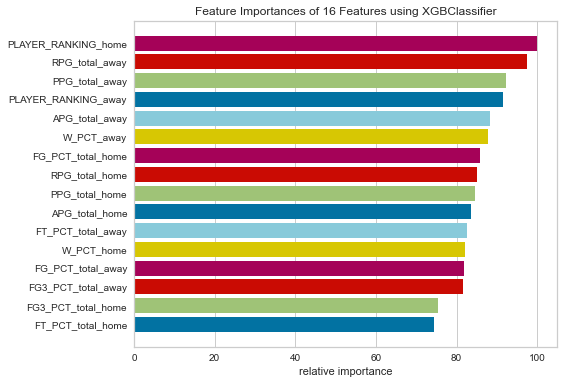

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({'reg_lambda': 0.05}): 0.71
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       880
           1       0.64      0.47      0.54       496

    accuracy                           0.71      1376
   macro avg       0.69      0.66      0.67      1376
weighted avg       0.70      0.71      0.70      1376



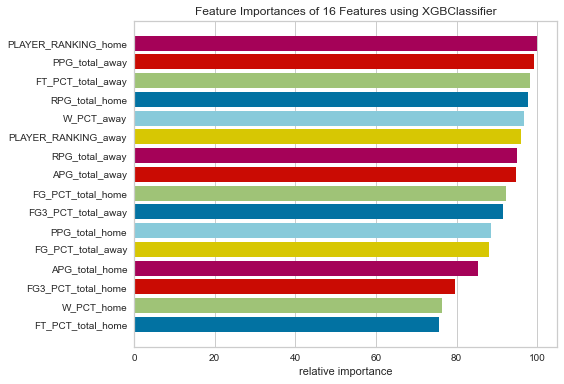

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({'reg_lambda': 0.25}): 0.71
              precision    recall  f1-score   support

           0       0.73      0.85      0.78       874
           1       0.63      0.46      0.53       502

    accuracy                           0.71      1376
   macro avg       0.68      0.65      0.66      1376
weighted avg       0.70      0.71      0.69      1376



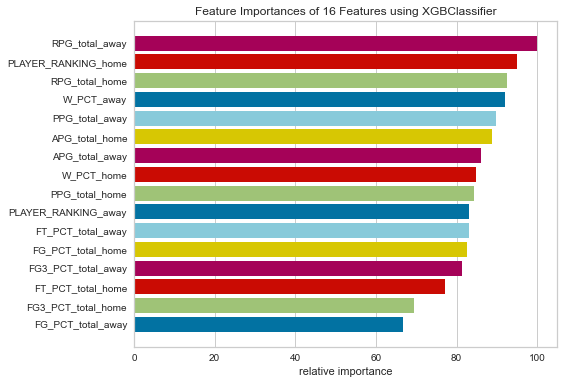

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({'reg_lambda': 0.2}): 0.69
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       868
           1       0.61      0.46      0.52       508

    accuracy                           0.69      1376
   macro avg       0.67      0.64      0.65      1376
weighted avg       0.68      0.69      0.68      1376



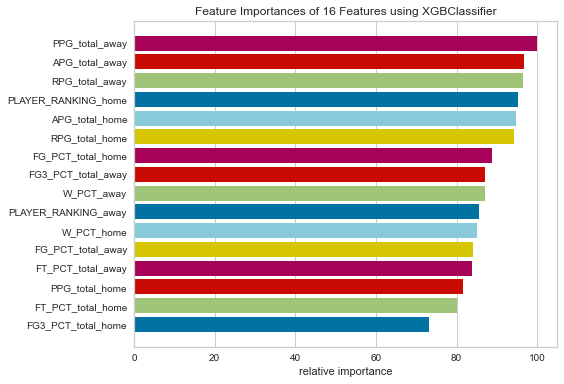

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({'reg_lambda': 0.2}): 0.71
              precision    recall  f1-score   support

           0       0.73      0.86      0.79       878
           1       0.65      0.45      0.53       498

    accuracy                           0.71      1376
   macro avg       0.69      0.66      0.66      1376
weighted avg       0.70      0.71      0.70      1376



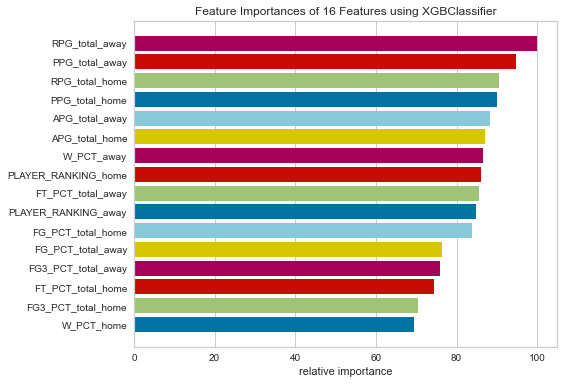

---------------------------------------------
Mean accuracy: 0.7089389534883721
Max accuracy: 0.7252906976744186
Min accuracy: 0.6911337209302325
i=5
FGP:

Best XGBoost accuracy ({'reg_lambda': 0.3}): 0.67
              precision    recall  f1-score   support

           0       0.70      0.80      0.75       602
           1       0.60      0.46      0.52       385

    accuracy                           0.67       987
   macro avg       0.65      0.63      0.63       987
weighted avg       0.66      0.67      0.66       987



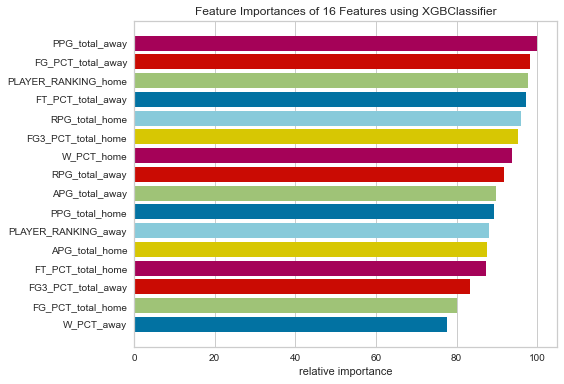

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({'reg_lambda': 0.4}): 0.64
              precision    recall  f1-score   support

           0       0.68      0.77      0.72       595
           1       0.56      0.46      0.50       391

    accuracy                           0.64       986
   macro avg       0.62      0.61      0.61       986
weighted avg       0.63      0.64      0.64       986



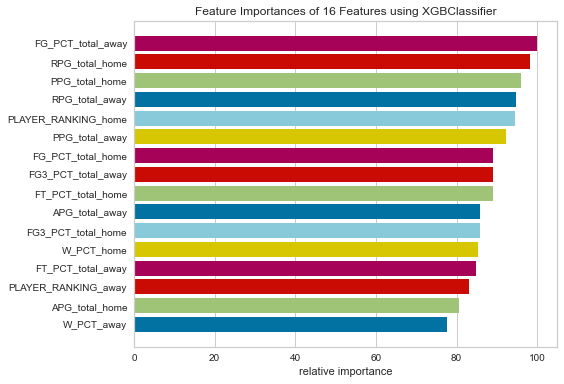

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({'reg_lambda': 0.05}): 0.66
              precision    recall  f1-score   support

           0       0.67      0.81      0.74       574
           1       0.63      0.45      0.52       412

    accuracy                           0.66       986
   macro avg       0.65      0.63      0.63       986
weighted avg       0.66      0.66      0.65       986



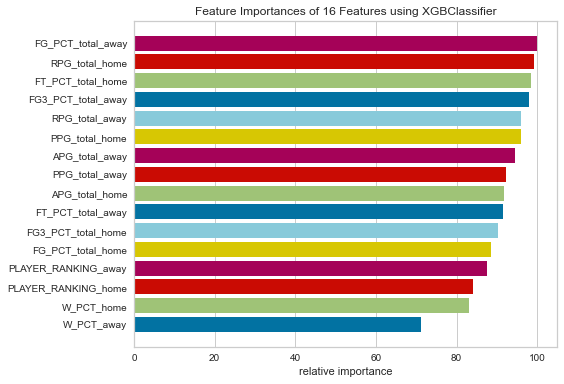

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({'reg_lambda': 0.9}): 0.68
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       612
           1       0.60      0.48      0.53       374

    accuracy                           0.68       986
   macro avg       0.66      0.64      0.64       986
weighted avg       0.67      0.68      0.67       986



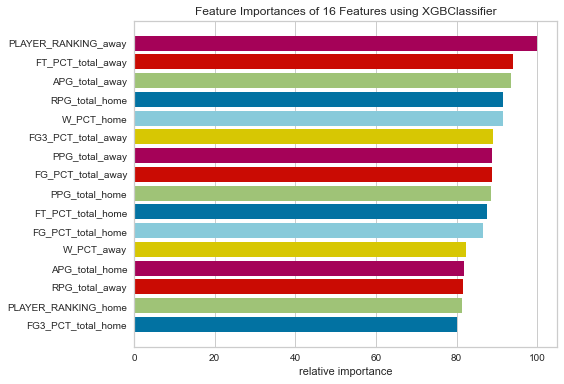

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({'reg_lambda': 0.0}): 0.64
              precision    recall  f1-score   support

           0       0.66      0.79      0.72       572
           1       0.60      0.44      0.51       414

    accuracy                           0.64       986
   macro avg       0.63      0.62      0.62       986
weighted avg       0.64      0.64      0.63       986



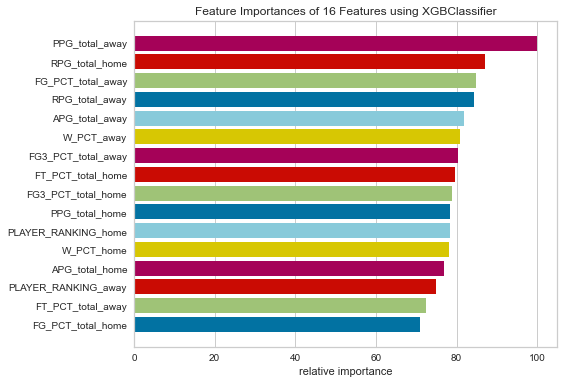

---------------------------------------------
Mean accuracy: 0.6633700068435298
Max accuracy: 0.6805273833671399
Min accuracy: 0.6440162271805274
i=10
FG3:

Best XGBoost accuracy ({'reg_lambda': 0.2}): 0.65
              precision    recall  f1-score   support

           0       0.64      0.72      0.68       325
           1       0.66      0.57      0.61       304

    accuracy                           0.65       629
   macro avg       0.65      0.65      0.65       629
weighted avg       0.65      0.65      0.65       629



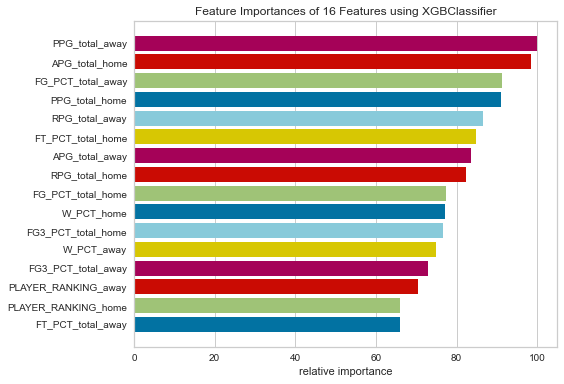

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({'reg_lambda': 0.7}): 0.62
              precision    recall  f1-score   support

           0       0.64      0.64      0.64       326
           1       0.61      0.61      0.61       303

    accuracy                           0.62       629
   macro avg       0.62      0.62      0.62       629
weighted avg       0.62      0.62      0.62       629



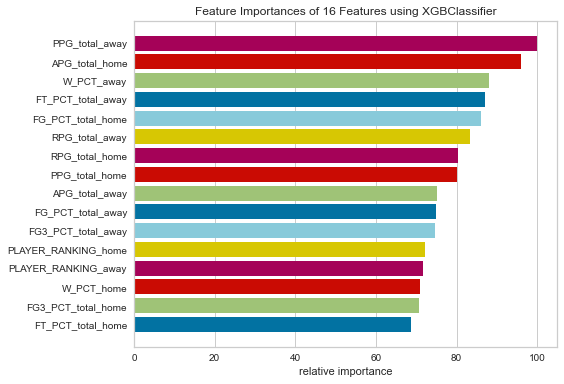

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({'reg_lambda': 0.65}): 0.62
              precision    recall  f1-score   support

           0       0.65      0.64      0.65       345
           1       0.57      0.58      0.58       284

    accuracy                           0.62       629
   macro avg       0.61      0.61      0.61       629
weighted avg       0.62      0.62      0.62       629



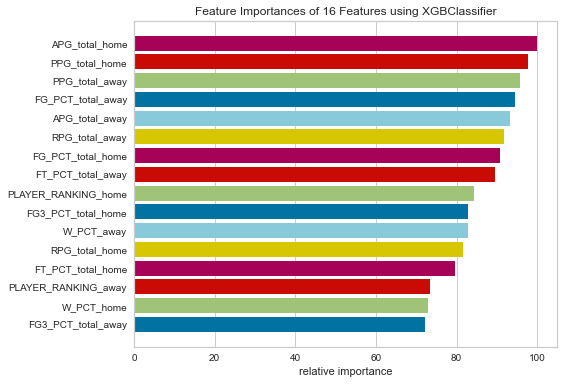

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({'reg_lambda': 0.3}): 0.61
              precision    recall  f1-score   support

           0       0.61      0.67      0.64       325
           1       0.60      0.54      0.57       304

    accuracy                           0.61       629
   macro avg       0.61      0.60      0.60       629
weighted avg       0.61      0.61      0.60       629



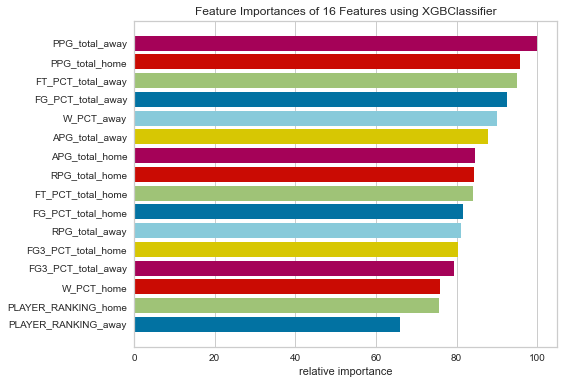

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({'reg_lambda': 0.95}): 0.63
              precision    recall  f1-score   support

           0       0.65      0.63      0.64       332
           1       0.60      0.62      0.61       296

    accuracy                           0.63       628
   macro avg       0.63      0.63      0.63       628
weighted avg       0.63      0.63      0.63       628



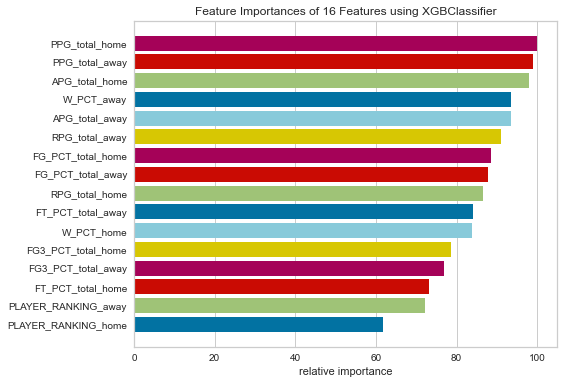

---------------------------------------------
Mean accuracy: 0.6236089030206677
Max accuracy: 0.6486486486486487
Min accuracy: 0.6057233704292527
i=15
FT:

Best XGBoost accuracy ({'reg_lambda': 0.65}): 0.63
              precision    recall  f1-score   support

           0       0.60      0.62      0.61       301
           1       0.65      0.64      0.64       337

    accuracy                           0.63       638
   macro avg       0.63      0.63      0.63       638
weighted avg       0.63      0.63      0.63       638



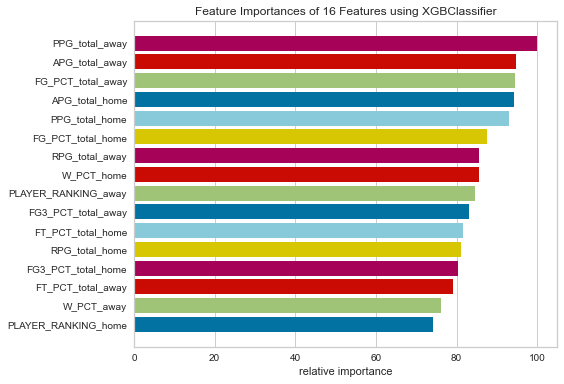

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({'reg_lambda': 0.8}): 0.61
              precision    recall  f1-score   support

           0       0.59      0.61      0.60       301
           1       0.64      0.62      0.63       337

    accuracy                           0.61       638
   macro avg       0.61      0.61      0.61       638
weighted avg       0.62      0.61      0.61       638



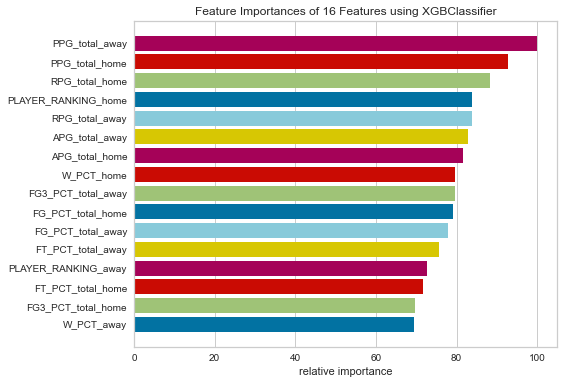

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({'reg_lambda': 0.25}): 0.61
              precision    recall  f1-score   support

           0       0.64      0.57      0.60       334
           1       0.58      0.65      0.62       304

    accuracy                           0.61       638
   macro avg       0.61      0.61      0.61       638
weighted avg       0.61      0.61      0.61       638



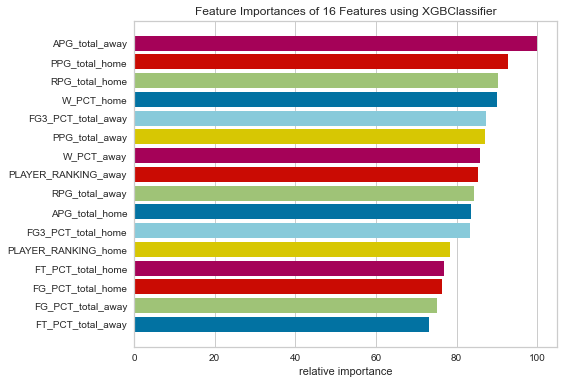

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({'reg_lambda': 1}): 0.63
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       298
           1       0.65      0.65      0.65       339

    accuracy                           0.63       637
   macro avg       0.63      0.63      0.63       637
weighted avg       0.63      0.63      0.63       637



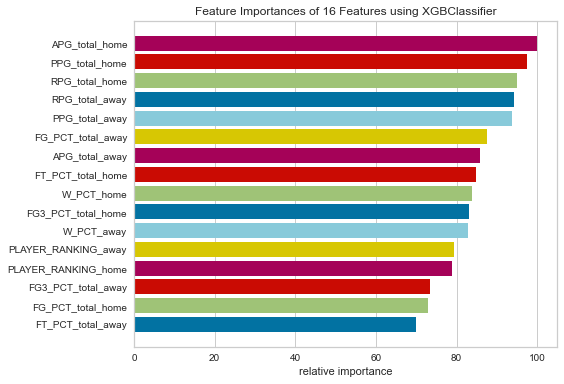

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({'reg_lambda': 0.5}): 0.60
              precision    recall  f1-score   support

           0       0.60      0.57      0.58       314
           1       0.60      0.63      0.61       323

    accuracy                           0.60       637
   macro avg       0.60      0.60      0.60       637
weighted avg       0.60      0.60      0.60       637



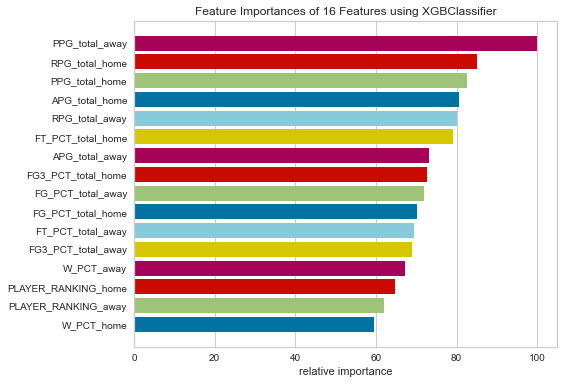

---------------------------------------------
Mean accuracy: 0.620936329680172
Max accuracy: 0.6300940438871473
Min accuracy: 0.609717868338558
i=20
AST:

Best XGBoost accuracy ({'reg_lambda': 0.1}): 0.66
              precision    recall  f1-score   support

           0       0.68      0.78      0.73       570
           1       0.62      0.49      0.55       405

    accuracy                           0.66       975
   macro avg       0.65      0.64      0.64       975
weighted avg       0.66      0.66      0.65       975



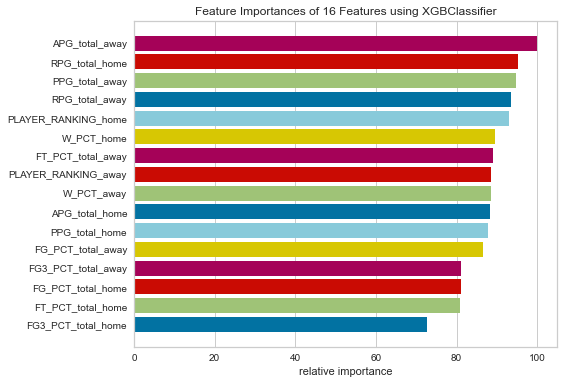

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({'reg_lambda': 0.0}): 0.65
              precision    recall  f1-score   support

           0       0.69      0.74      0.72       592
           1       0.55      0.49      0.52       382

    accuracy                           0.65       974
   macro avg       0.62      0.62      0.62       974
weighted avg       0.64      0.65      0.64       974



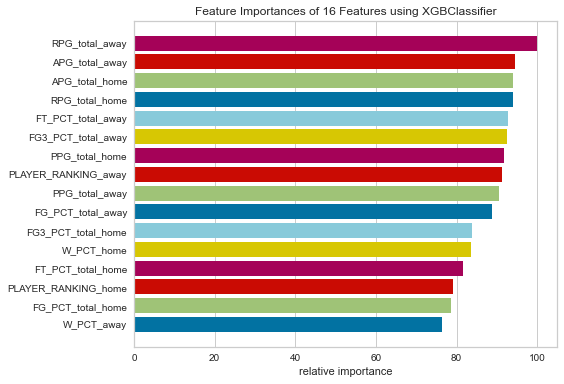

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({'reg_lambda': 0.1}): 0.65
              precision    recall  f1-score   support

           0       0.67      0.76      0.71       561
           1       0.60      0.49      0.54       413

    accuracy                           0.65       974
   macro avg       0.64      0.63      0.63       974
weighted avg       0.64      0.65      0.64       974



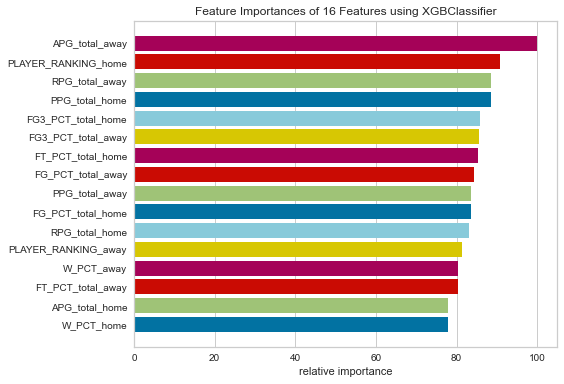

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({'reg_lambda': 0.85}): 0.63
              precision    recall  f1-score   support

           0       0.68      0.75      0.71       596
           1       0.53      0.44      0.48       378

    accuracy                           0.63       974
   macro avg       0.60      0.60      0.60       974
weighted avg       0.62      0.63      0.62       974



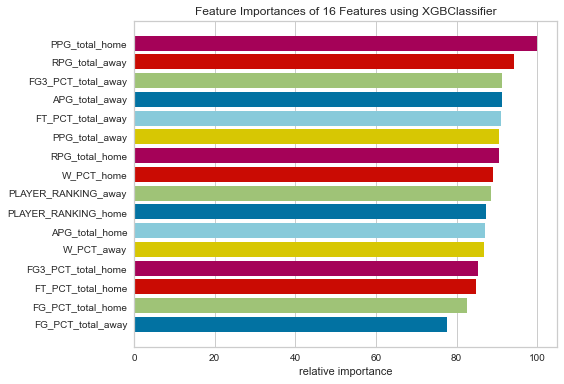

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({'reg_lambda': 0.75}): 0.67
              precision    recall  f1-score   support

           0       0.67      0.83      0.74       564
           1       0.65      0.45      0.53       410

    accuracy                           0.67       974
   macro avg       0.66      0.64      0.64       974
weighted avg       0.66      0.67      0.65       974



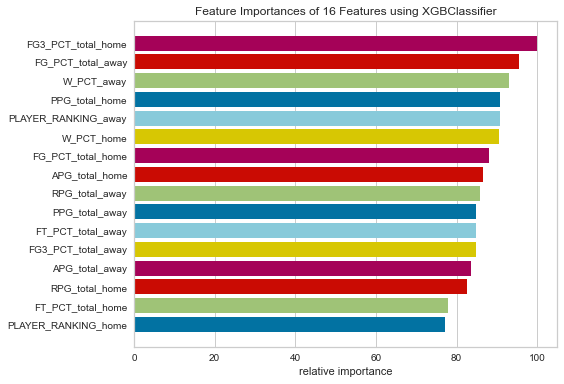

---------------------------------------------
Mean accuracy: 0.6461341020375928
Max accuracy: 0.6615384615384615
Min accuracy: 0.6293634496919918
i=25
REB:

Best XGBoost accuracy ({'reg_lambda': 0.6}): 0.65
              precision    recall  f1-score   support

           0       0.68      0.75      0.72       498
           1       0.58      0.49      0.53       342

    accuracy                           0.65       840
   macro avg       0.63      0.62      0.62       840
weighted avg       0.64      0.65      0.64       840



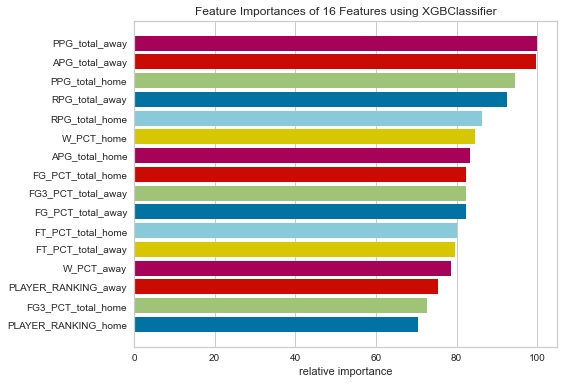

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({'reg_lambda': 0.55}): 0.66
              precision    recall  f1-score   support

           0       0.67      0.78      0.72       471
           1       0.65      0.52      0.58       369

    accuracy                           0.66       840
   macro avg       0.66      0.65      0.65       840
weighted avg       0.66      0.66      0.66       840



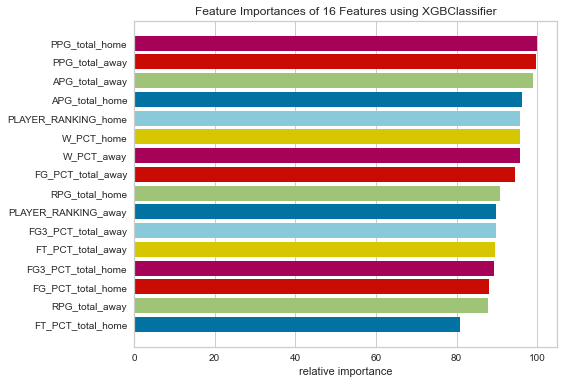

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({'reg_lambda': 0.5}): 0.64
              precision    recall  f1-score   support

           0       0.65      0.76      0.70       473
           1       0.61      0.47      0.53       366

    accuracy                           0.64       839
   macro avg       0.63      0.62      0.62       839
weighted avg       0.63      0.64      0.63       839



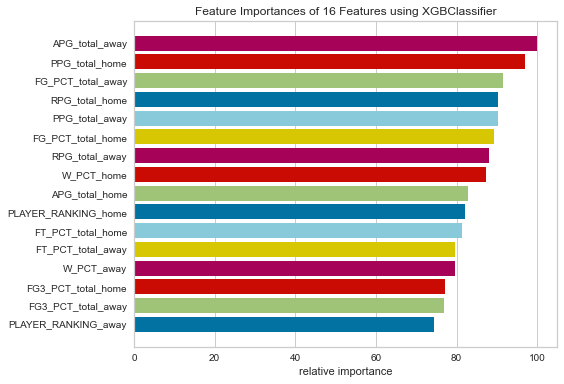

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({'reg_lambda': 0.75}): 0.66
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       516
           1       0.56      0.55      0.55       323

    accuracy                           0.66       839
   macro avg       0.64      0.64      0.64       839
weighted avg       0.66      0.66      0.66       839



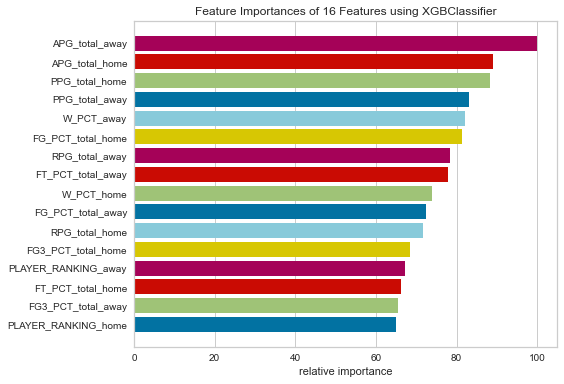

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({'reg_lambda': 0.4}): 0.64
              precision    recall  f1-score   support

           0       0.64      0.78      0.70       465
           1       0.63      0.46      0.53       374

    accuracy                           0.64       839
   macro avg       0.63      0.62      0.62       839
weighted avg       0.63      0.64      0.63       839



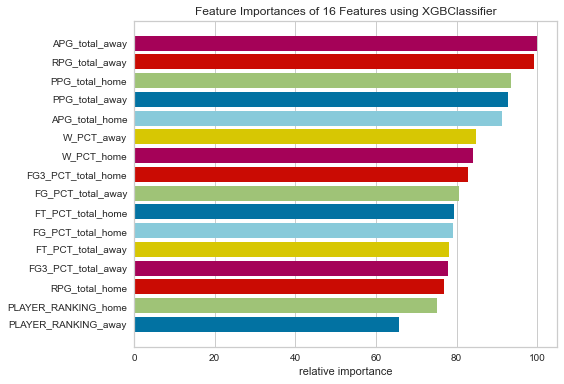

---------------------------------------------
Mean accuracy: 0.6509804756229071
Max accuracy: 0.6642857142857143
Min accuracy: 0.636471990464839


In [34]:
# L2 regularization term on weights. Increasing this value will make model more conservative.

print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'reg_lambda': [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
})

## Try prune gamma

i=0
WINNER:

Best XGBoost accuracy ({'gamma': 27}): 0.64
              precision    recall  f1-score   support

           0       0.64      0.99      0.77       858
           1       0.77      0.06      0.12       518

    accuracy                           0.64      1376
   macro avg       0.70      0.53      0.45      1376
weighted avg       0.69      0.64      0.53      1376



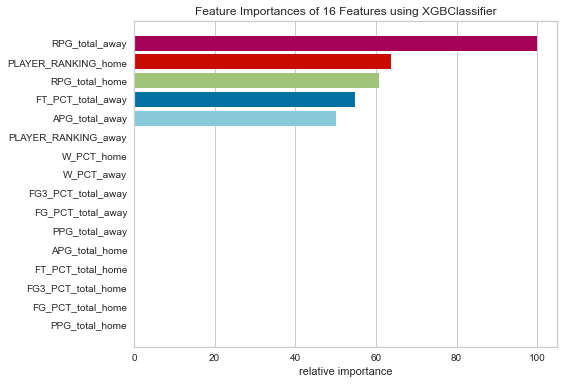

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({'gamma': 28}): 0.65
              precision    recall  f1-score   support

           0       0.65      0.99      0.78       880
           1       0.63      0.04      0.08       496

    accuracy                           0.65      1376
   macro avg       0.64      0.51      0.43      1376
weighted avg       0.64      0.65      0.53      1376



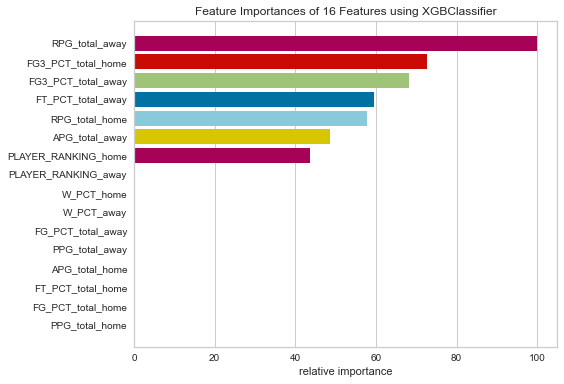

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({'gamma': 29}): 0.65
              precision    recall  f1-score   support

           0       0.64      0.99      0.78       874
           1       0.71      0.05      0.10       502

    accuracy                           0.65      1376
   macro avg       0.68      0.52      0.44      1376
weighted avg       0.67      0.65      0.53      1376



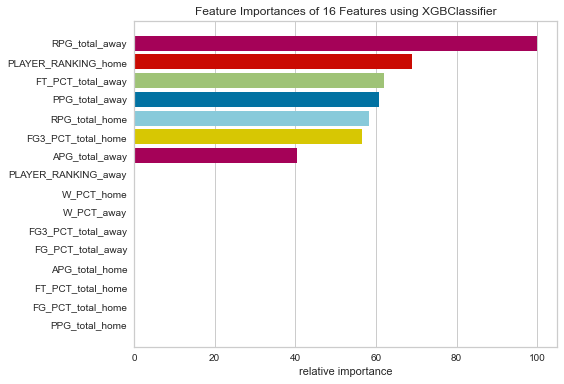

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({'gamma': 27}): 0.64
              precision    recall  f1-score   support

           0       0.64      0.99      0.78       868
           1       0.70      0.05      0.10       508

    accuracy                           0.64      1376
   macro avg       0.67      0.52      0.44      1376
weighted avg       0.66      0.64      0.53      1376



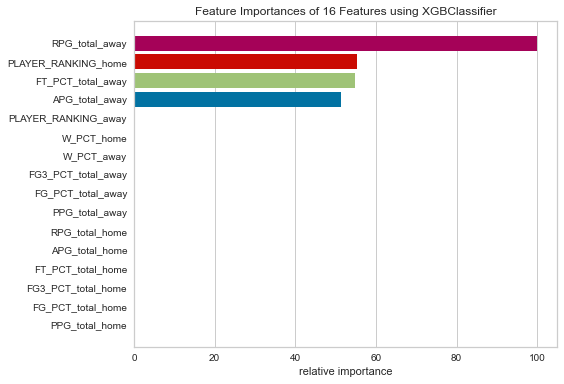

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({'gamma': 29}): 0.64
              precision    recall  f1-score   support

           0       0.64      0.99      0.78       878
           1       0.50      0.03      0.05       498

    accuracy                           0.64      1376
   macro avg       0.57      0.51      0.41      1376
weighted avg       0.59      0.64      0.51      1376



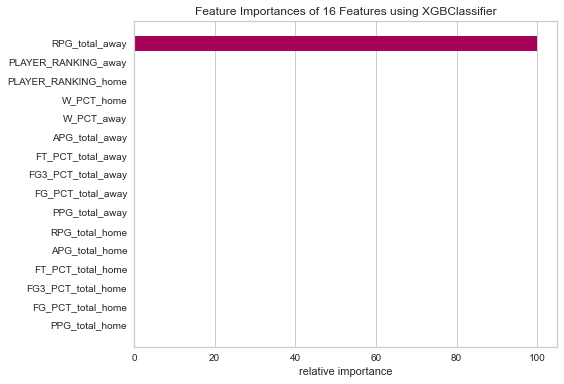

---------------------------------------------
Mean accuracy: 0.6437136627906976
Max accuracy: 0.6468023255813954
Min accuracy: 0.6402616279069767
i=5
FGP:

Best XGBoost accuracy ({'gamma': 27}): 0.61
              precision    recall  f1-score   support

           0       0.61      1.00      0.76       602
           1       0.00      0.00      0.00       385

    accuracy                           0.61       987
   macro avg       0.30      0.50      0.38       987
weighted avg       0.37      0.61      0.46       987



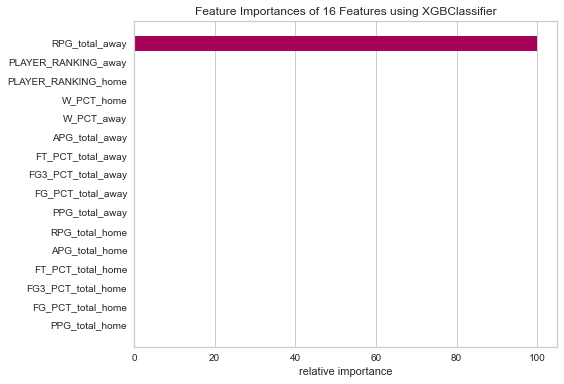

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({'gamma': 27}): 0.60
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       595
           1       0.00      0.00      0.00       391

    accuracy                           0.60       986
   macro avg       0.30      0.50      0.38       986
weighted avg       0.36      0.60      0.45       986



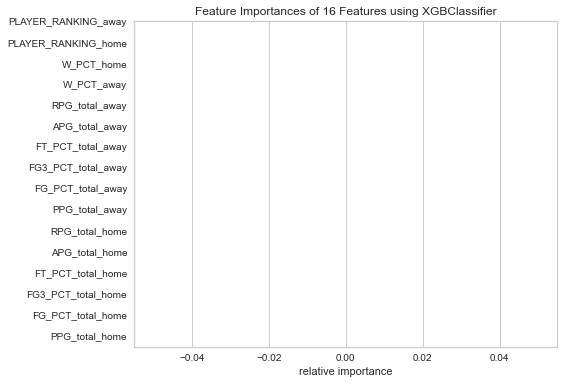

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({'gamma': 29}): 0.58
              precision    recall  f1-score   support

           0       0.58      1.00      0.74       574
           1       0.00      0.00      0.00       412

    accuracy                           0.58       986
   macro avg       0.29      0.50      0.37       986
weighted avg       0.34      0.58      0.43       986



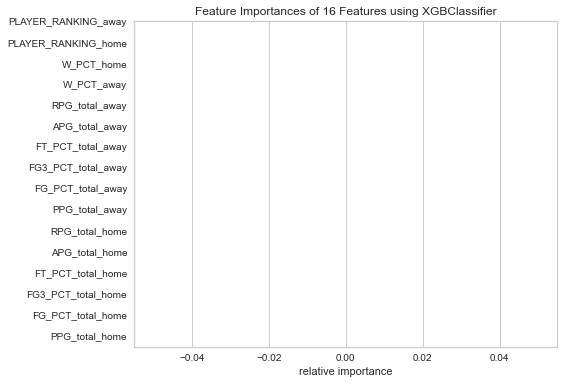

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({'gamma': 22}): 0.62
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       612
           1       0.00      0.00      0.00       374

    accuracy                           0.62       986
   macro avg       0.31      0.50      0.38       986
weighted avg       0.39      0.62      0.48       986



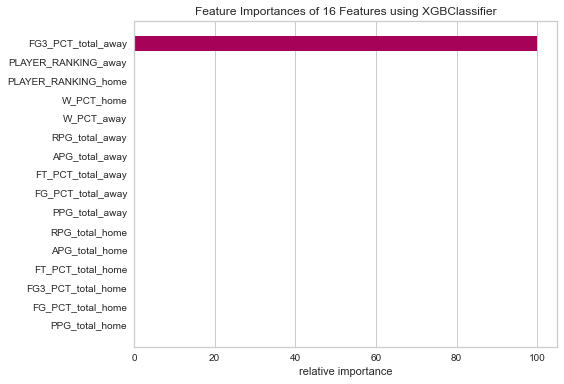

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({'gamma': 27}): 0.58
              precision    recall  f1-score   support

           0       0.58      1.00      0.73       572
           1       0.00      0.00      0.00       414

    accuracy                           0.58       986
   macro avg       0.29      0.50      0.37       986
weighted avg       0.34      0.58      0.43       986



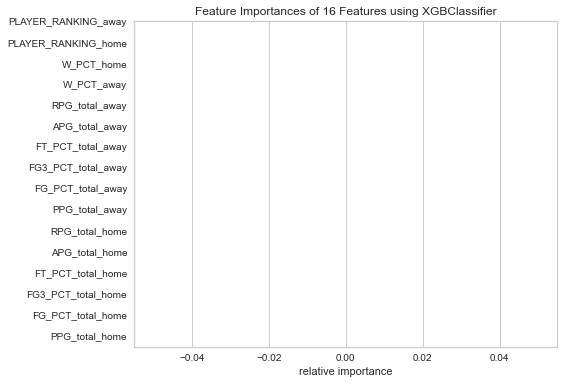

---------------------------------------------
Mean accuracy: 0.6040542776171364
Max accuracy: 0.6206896551724138
Min accuracy: 0.5821501014198783
i=10
FG3:

Best XGBoost accuracy ({'gamma': 0}): 0.62
              precision    recall  f1-score   support

           0       0.62      0.68      0.65       325
           1       0.62      0.56      0.59       304

    accuracy                           0.62       629
   macro avg       0.62      0.62      0.62       629
weighted avg       0.62      0.62      0.62       629



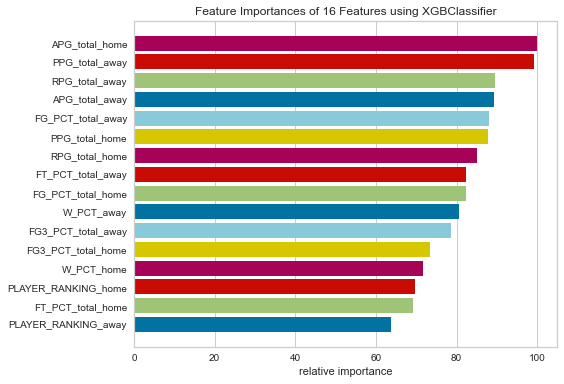

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({'gamma': 1}): 0.60
              precision    recall  f1-score   support

           0       0.61      0.64      0.62       326
           1       0.59      0.56      0.58       303

    accuracy                           0.60       629
   macro avg       0.60      0.60      0.60       629
weighted avg       0.60      0.60      0.60       629



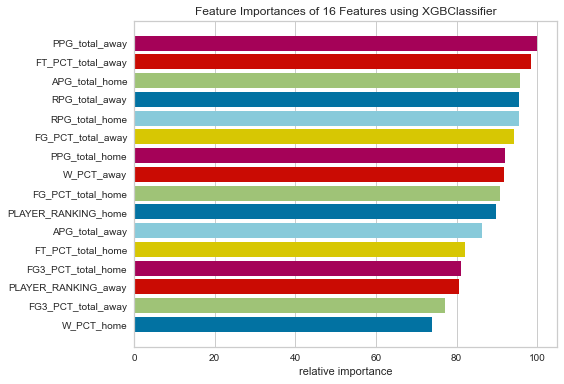

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({'gamma': 2}): 0.61
              precision    recall  f1-score   support

           0       0.64      0.65      0.64       345
           1       0.56      0.55      0.56       284

    accuracy                           0.61       629
   macro avg       0.60      0.60      0.60       629
weighted avg       0.61      0.61      0.61       629



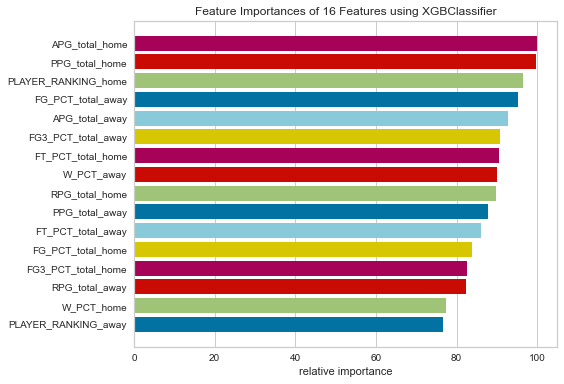

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({'gamma': 2}): 0.60
              precision    recall  f1-score   support

           0       0.61      0.65      0.63       325
           1       0.60      0.56      0.57       304

    accuracy                           0.60       629
   macro avg       0.60      0.60      0.60       629
weighted avg       0.60      0.60      0.60       629



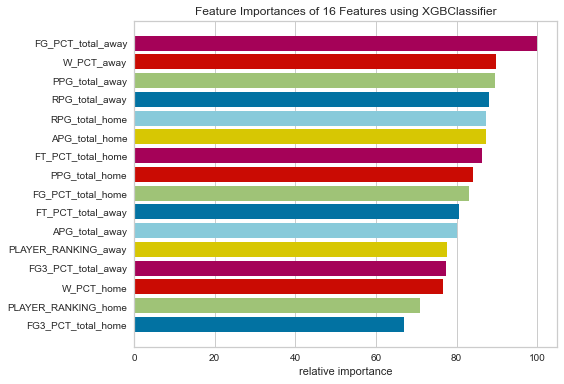

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({'gamma': 7}): 0.59
              precision    recall  f1-score   support

           0       0.60      0.64      0.62       332
           1       0.57      0.53      0.55       296

    accuracy                           0.59       628
   macro avg       0.59      0.58      0.58       628
weighted avg       0.59      0.59      0.59       628



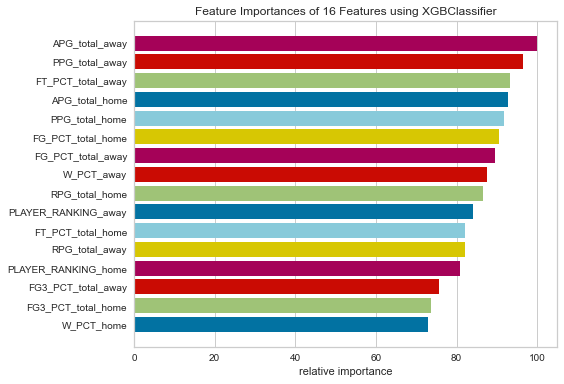

---------------------------------------------
Mean accuracy: 0.6077106518282989
Max accuracy: 0.6216216216216216
Min accuracy: 0.6009538950715422
i=15
FT:

Best XGBoost accuracy ({'gamma': 1}): 0.62
              precision    recall  f1-score   support

           0       0.60      0.61      0.60       301
           1       0.65      0.64      0.64       337

    accuracy                           0.62       638
   macro avg       0.62      0.62      0.62       638
weighted avg       0.62      0.62      0.62       638



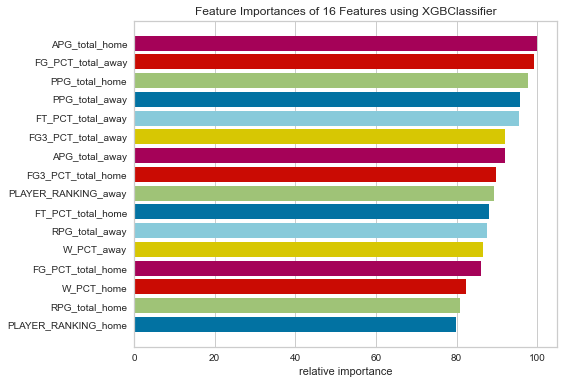

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({'gamma': 14}): 0.59
              precision    recall  f1-score   support

           0       0.57      0.53      0.55       301
           1       0.60      0.64      0.62       337

    accuracy                           0.59       638
   macro avg       0.59      0.58      0.58       638
weighted avg       0.59      0.59      0.59       638



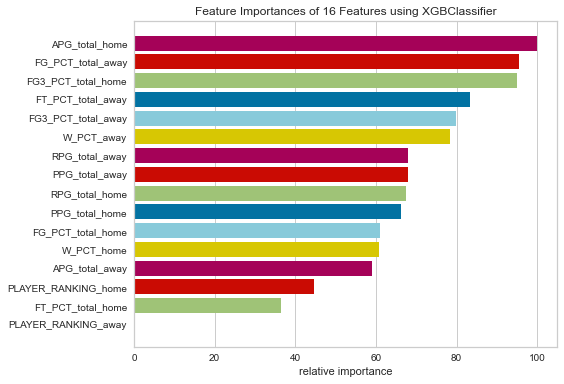

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({'gamma': 4}): 0.61
              precision    recall  f1-score   support

           0       0.65      0.56      0.60       334
           1       0.58      0.68      0.63       304

    accuracy                           0.61       638
   macro avg       0.62      0.62      0.61       638
weighted avg       0.62      0.61      0.61       638



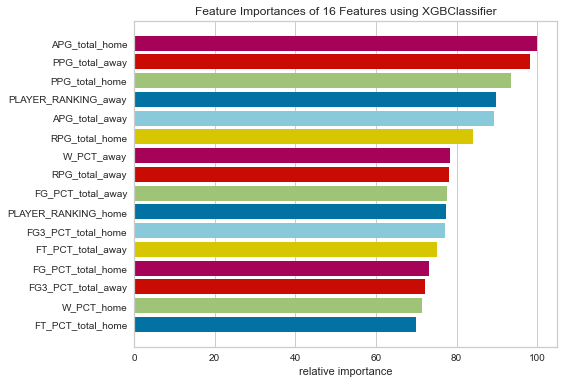

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({'gamma': 5}): 0.58
              precision    recall  f1-score   support

           0       0.55      0.56      0.55       298
           1       0.60      0.59      0.60       339

    accuracy                           0.58       637
   macro avg       0.57      0.57      0.57       637
weighted avg       0.58      0.58      0.58       637



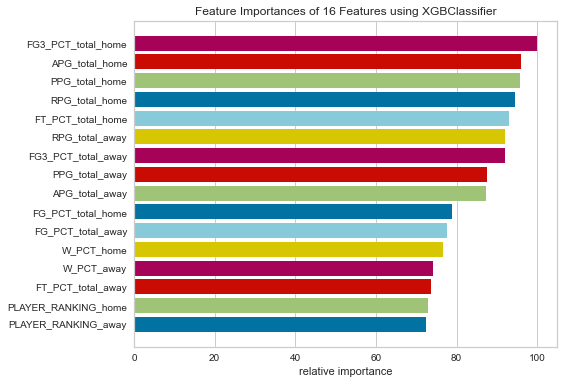

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({'gamma': 1}): 0.59
              precision    recall  f1-score   support

           0       0.58      0.59      0.59       314
           1       0.60      0.59      0.59       323

    accuracy                           0.59       637
   macro avg       0.59      0.59      0.59       637
weighted avg       0.59      0.59      0.59       637



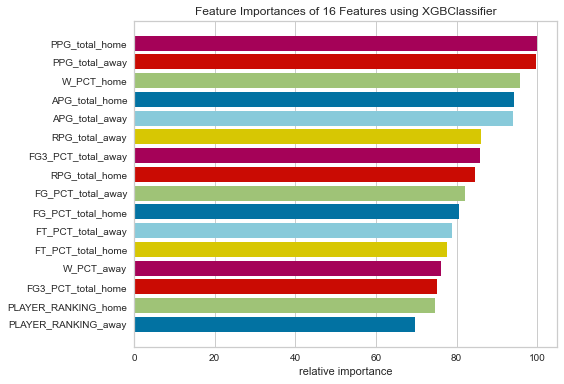

---------------------------------------------
Mean accuracy: 0.6005392390860371
Max accuracy: 0.6238244514106583
Min accuracy: 0.576138147566719
i=20
AST:

Best XGBoost accuracy ({'gamma': 24}): 0.58
              precision    recall  f1-score   support

           0       0.58      1.00      0.74       570
           1       0.00      0.00      0.00       405

    accuracy                           0.58       975
   macro avg       0.29      0.50      0.37       975
weighted avg       0.34      0.58      0.43       975



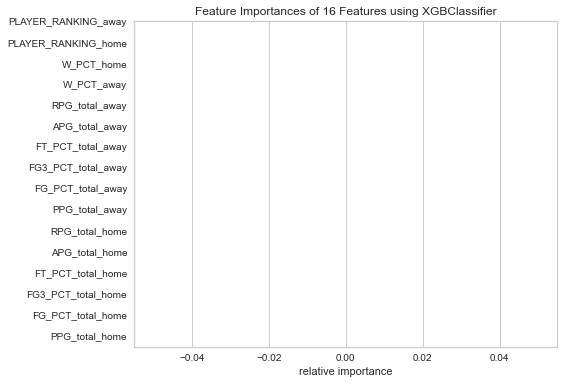

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({'gamma': 28}): 0.61
              precision    recall  f1-score   support

           0       0.61      1.00      0.76       592
           1       0.00      0.00      0.00       382

    accuracy                           0.61       974
   macro avg       0.30      0.50      0.38       974
weighted avg       0.37      0.61      0.46       974



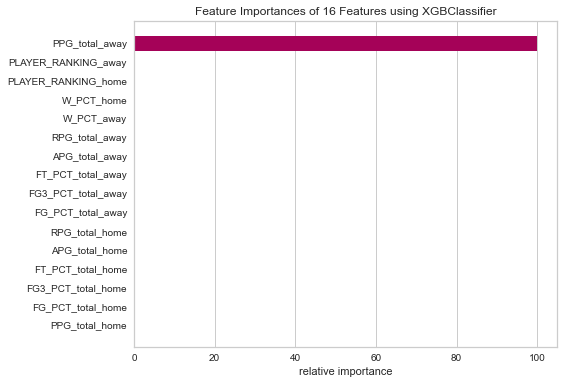

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({'gamma': 25}): 0.58
              precision    recall  f1-score   support

           0       0.58      1.00      0.73       561
           1       0.00      0.00      0.00       413

    accuracy                           0.58       974
   macro avg       0.29      0.50      0.37       974
weighted avg       0.33      0.58      0.42       974



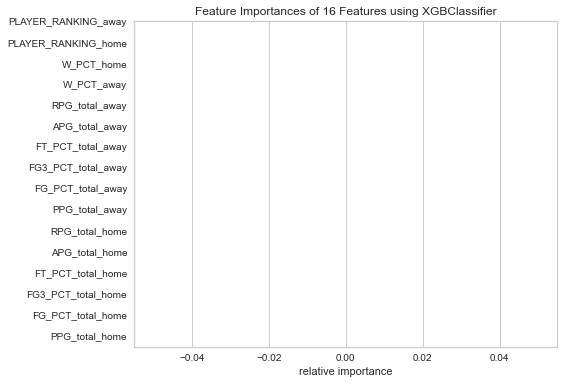

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({'gamma': 26}): 0.61
              precision    recall  f1-score   support

           0       0.61      1.00      0.76       596
           1       0.00      0.00      0.00       378

    accuracy                           0.61       974
   macro avg       0.31      0.50      0.38       974
weighted avg       0.37      0.61      0.46       974



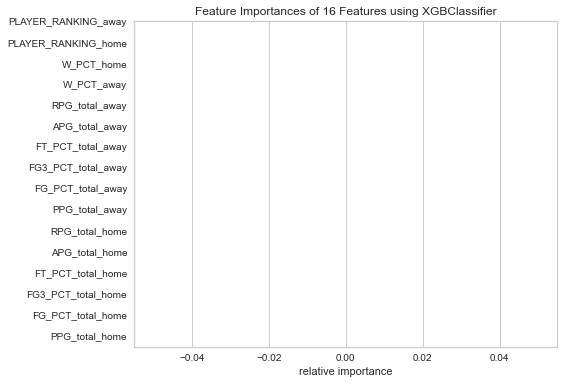

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({'gamma': 27}): 0.58
              precision    recall  f1-score   support

           0       0.58      1.00      0.73       564
           1       0.00      0.00      0.00       410

    accuracy                           0.58       974
   macro avg       0.29      0.50      0.37       974
weighted avg       0.34      0.58      0.42       974



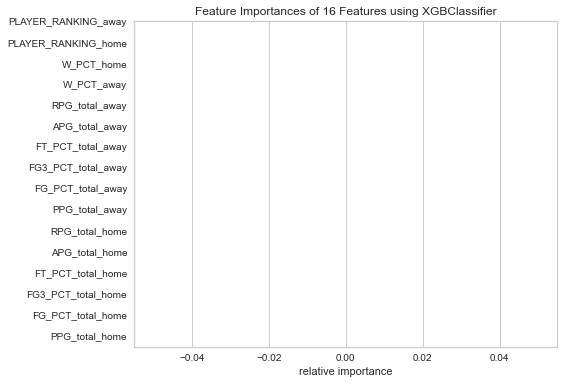

---------------------------------------------
Mean accuracy: 0.5950758174064129
Max accuracy: 0.6119096509240246
Min accuracy: 0.5759753593429158
i=25
REB:

Best XGBoost accuracy ({'gamma': 23}): 0.59
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       498
           1       0.00      0.00      0.00       342

    accuracy                           0.59       840
   macro avg       0.30      0.50      0.37       840
weighted avg       0.35      0.59      0.44       840



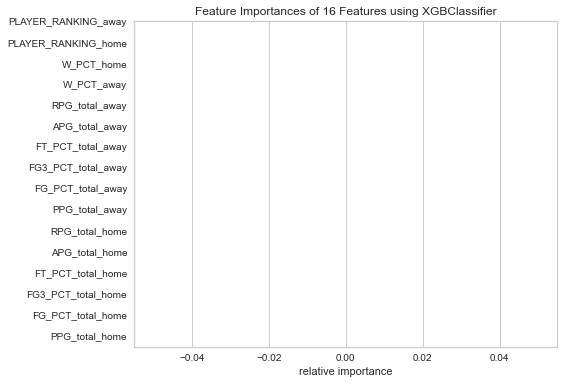

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({'gamma': 29}): 0.56
              precision    recall  f1-score   support

           0       0.56      1.00      0.72       471
           1       0.00      0.00      0.00       369

    accuracy                           0.56       840
   macro avg       0.28      0.50      0.36       840
weighted avg       0.31      0.56      0.40       840



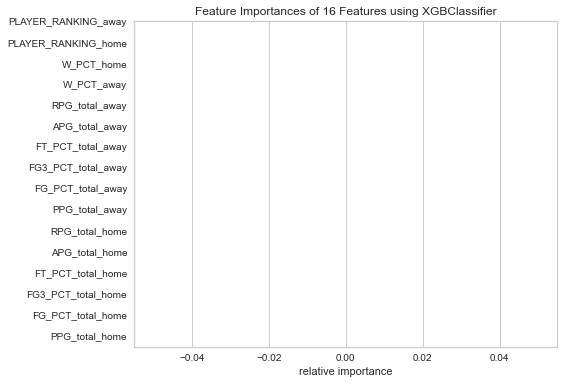

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({'gamma': 26}): 0.56
              precision    recall  f1-score   support

           0       0.56      1.00      0.72       473
           1       0.00      0.00      0.00       366

    accuracy                           0.56       839
   macro avg       0.28      0.50      0.36       839
weighted avg       0.32      0.56      0.41       839



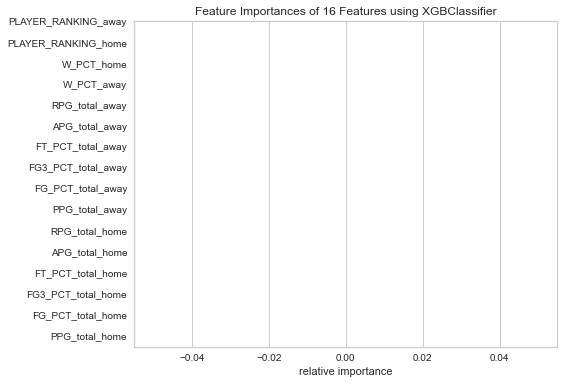

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({'gamma': 29}): 0.62
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       516
           1       0.00      0.00      0.00       323

    accuracy                           0.62       839
   macro avg       0.31      0.50      0.38       839
weighted avg       0.38      0.62      0.47       839



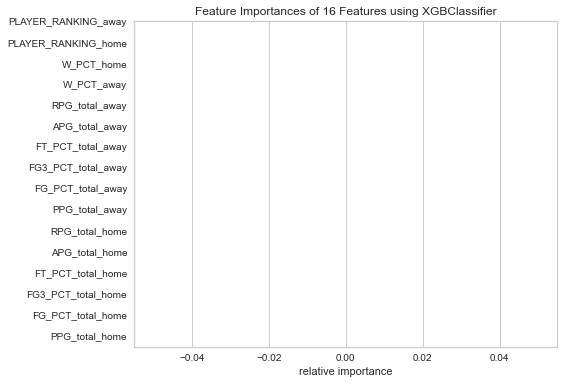

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({'gamma': 27}): 0.56
              precision    recall  f1-score   support

           0       0.56      0.99      0.71       465
           1       0.67      0.03      0.05       374

    accuracy                           0.56       839
   macro avg       0.61      0.51      0.38       839
weighted avg       0.61      0.56      0.42       839



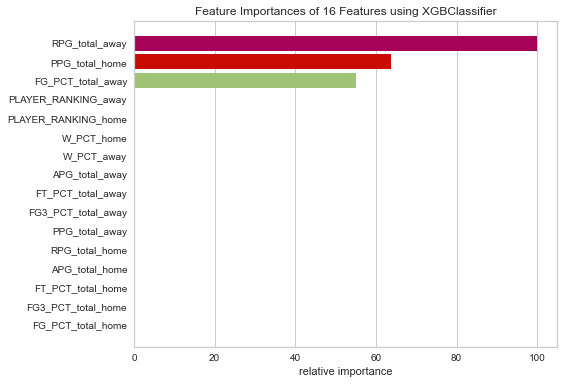

---------------------------------------------
Mean accuracy: 0.5830889238889835
Max accuracy: 0.6150178784266984
Min accuracy: 0.5607142857142857


In [35]:
# Minimum loss reduction required to make a further partition on a leaf node of the tree. 
# The larger gamma is, the more conservative the algorithm will be.

print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'gamma' : [*range(0,30)],
})

## Try prune sclae_pos_weight

i=0
WINNER:

Best XGBoost accuracy ({'scale_pos_weight': 2}): 0.70
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       858
           1       0.60      0.57      0.59       518

    accuracy                           0.70      1376
   macro avg       0.68      0.67      0.67      1376
weighted avg       0.69      0.70      0.69      1376



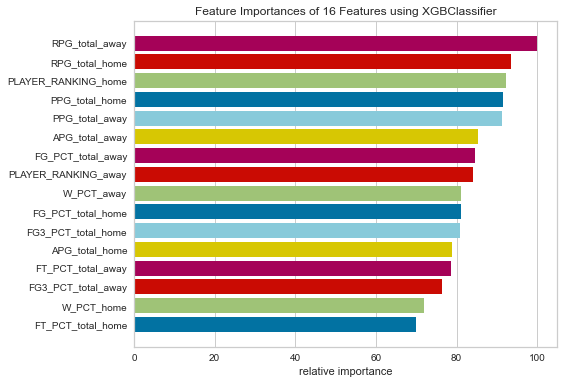

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({'scale_pos_weight': 5}): 0.68
              precision    recall  f1-score   support

           0       0.80      0.67      0.73       880
           1       0.55      0.70      0.61       496

    accuracy                           0.68      1376
   macro avg       0.67      0.69      0.67      1376
weighted avg       0.71      0.68      0.69      1376



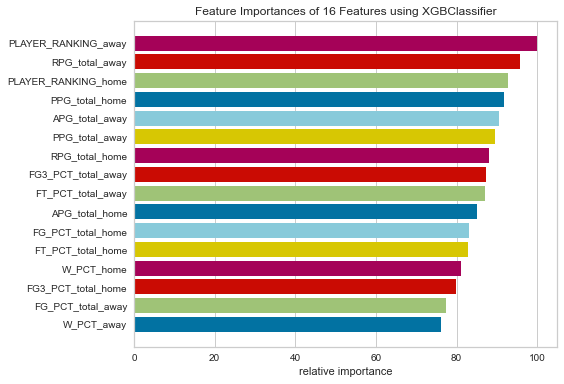

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({'scale_pos_weight': 5}): 0.66
              precision    recall  f1-score   support

           0       0.80      0.63      0.70       874
           1       0.53      0.72      0.61       502

    accuracy                           0.66      1376
   macro avg       0.66      0.68      0.66      1376
weighted avg       0.70      0.66      0.67      1376



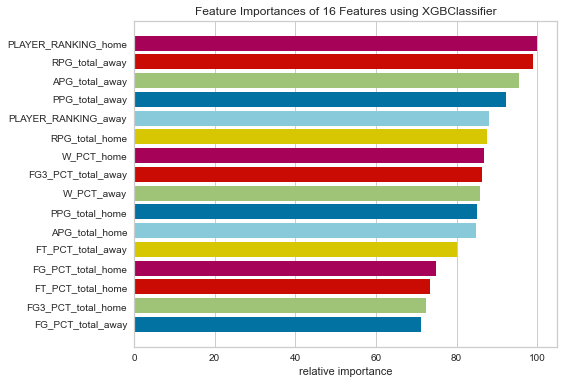

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({'scale_pos_weight': 3}): 0.70
              precision    recall  f1-score   support

           0       0.79      0.72      0.75       868
           1       0.58      0.67      0.62       508

    accuracy                           0.70      1376
   macro avg       0.68      0.69      0.69      1376
weighted avg       0.71      0.70      0.70      1376



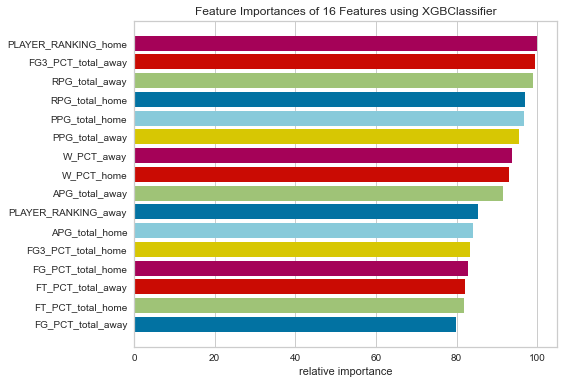

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({'scale_pos_weight': 2}): 0.71
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       878
           1       0.60      0.57      0.58       498

    accuracy                           0.71      1376
   macro avg       0.68      0.68      0.68      1376
weighted avg       0.70      0.71      0.70      1376



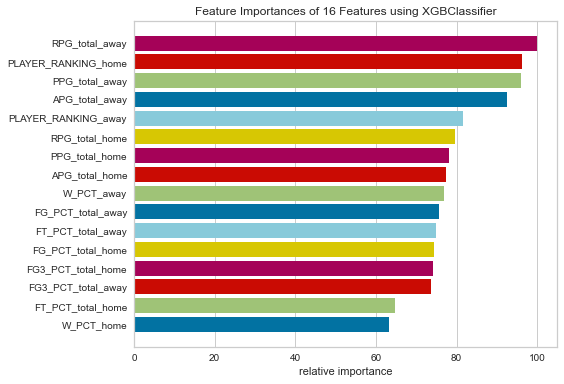

---------------------------------------------
Mean accuracy: 0.6851380813953487
Max accuracy: 0.6984011627906976
Min accuracy: 0.6627906976744186
i=5
FGP:

Best XGBoost accuracy ({'scale_pos_weight': 1}): 0.67
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       602
           1       0.61      0.45      0.52       385

    accuracy                           0.67       987
   macro avg       0.65      0.63      0.63       987
weighted avg       0.66      0.67      0.66       987



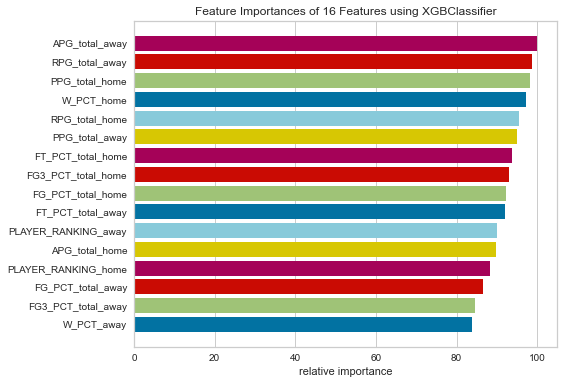

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({'scale_pos_weight': 1}): 0.68
              precision    recall  f1-score   support

           0       0.70      0.82      0.76       595
           1       0.63      0.46      0.53       391

    accuracy                           0.68       986
   macro avg       0.66      0.64      0.64       986
weighted avg       0.67      0.68      0.67       986



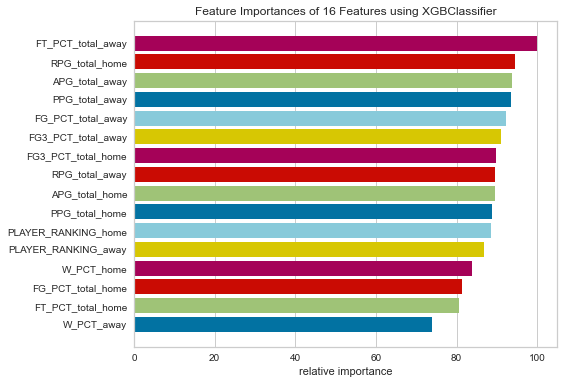

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({'scale_pos_weight': 3}): 0.66
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       574
           1       0.59      0.60      0.59       412

    accuracy                           0.66       986
   macro avg       0.65      0.65      0.65       986
weighted avg       0.66      0.66      0.66       986



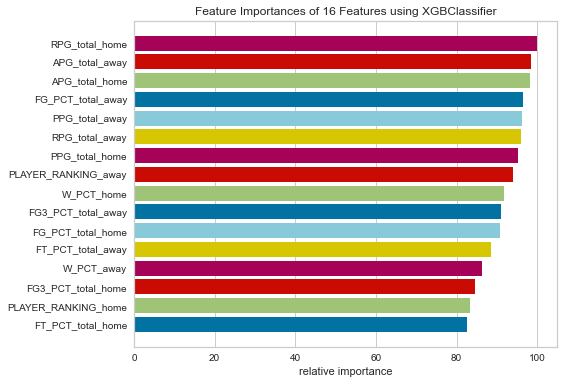

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.62
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       612
           1       0.00      0.00      0.00       374

    accuracy                           0.62       986
   macro avg       0.31      0.50      0.38       986
weighted avg       0.39      0.62      0.48       986



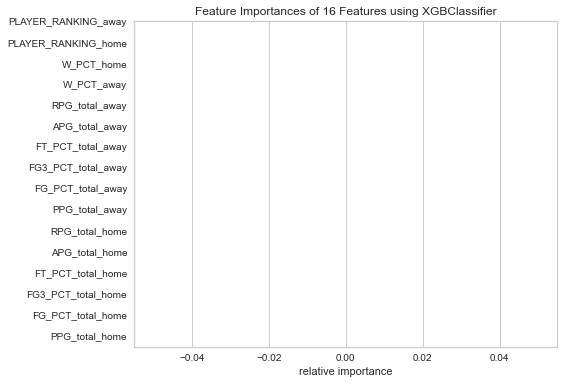

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({'scale_pos_weight': 1}): 0.64
              precision    recall  f1-score   support

           0       0.66      0.80      0.72       572
           1       0.61      0.42      0.50       414

    accuracy                           0.64       986
   macro avg       0.63      0.61      0.61       986
weighted avg       0.64      0.64      0.63       986



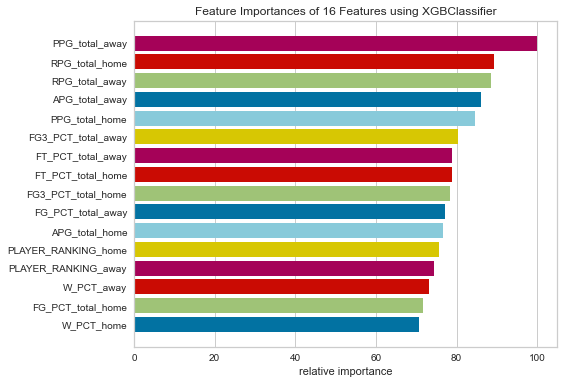

---------------------------------------------
Mean accuracy: 0.6575375931737332
Max accuracy: 0.6774847870182555
Min accuracy: 0.6206896551724138
i=10
FG3:

Best XGBoost accuracy ({'scale_pos_weight': 5}): 0.62
              precision    recall  f1-score   support

           0       0.67      0.52      0.58       325
           1       0.59      0.72      0.65       304

    accuracy                           0.62       629
   macro avg       0.63      0.62      0.62       629
weighted avg       0.63      0.62      0.61       629



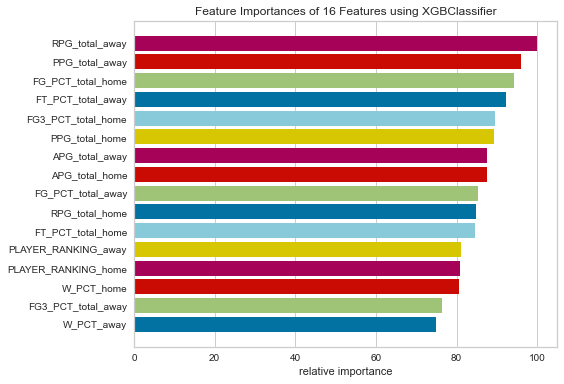

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({'scale_pos_weight': 14}): 0.60
              precision    recall  f1-score   support

           0       0.70      0.39      0.50       326
           1       0.56      0.82      0.66       303

    accuracy                           0.60       629
   macro avg       0.63      0.61      0.58       629
weighted avg       0.63      0.60      0.58       629



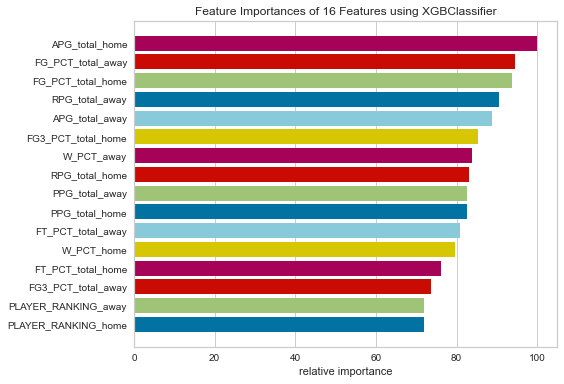

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({'scale_pos_weight': 1}): 0.65
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       345
           1       0.61      0.60      0.60       284

    accuracy                           0.65       629
   macro avg       0.64      0.64      0.64       629
weighted avg       0.64      0.65      0.65       629



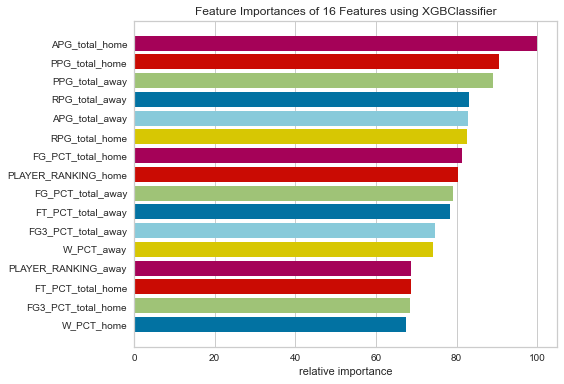

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({'scale_pos_weight': 14}): 0.60
              precision    recall  f1-score   support

           0       0.67      0.46      0.54       325
           1       0.57      0.76      0.65       304

    accuracy                           0.60       629
   macro avg       0.62      0.61      0.60       629
weighted avg       0.62      0.60      0.59       629



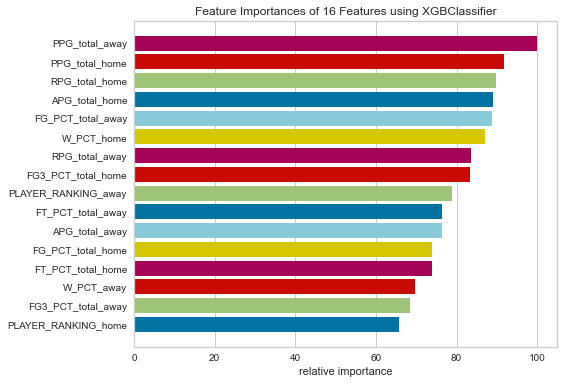

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({'scale_pos_weight': 4}): 0.62
              precision    recall  f1-score   support

           0       0.71      0.48      0.57       332
           1       0.57      0.78      0.66       296

    accuracy                           0.62       628
   macro avg       0.64      0.63      0.62       628
weighted avg       0.64      0.62      0.61       628



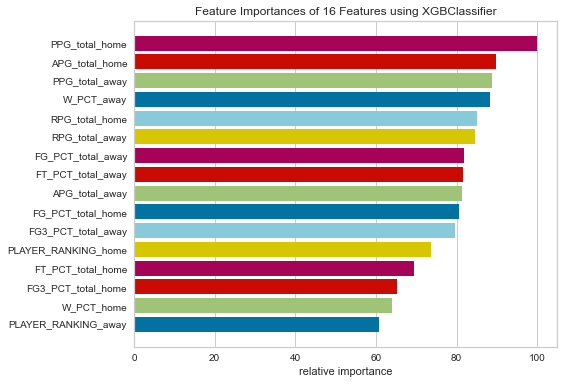

---------------------------------------------
Mean accuracy: 0.6160572337042926
Max accuracy: 0.6454689984101749
Min accuracy: 0.5977742448330684
i=15
FT:

Best XGBoost accuracy ({'scale_pos_weight': 4}): 0.60
              precision    recall  f1-score   support

           0       0.62      0.41      0.50       301
           1       0.60      0.77      0.67       337

    accuracy                           0.60       638
   macro avg       0.61      0.59      0.58       638
weighted avg       0.61      0.60      0.59       638



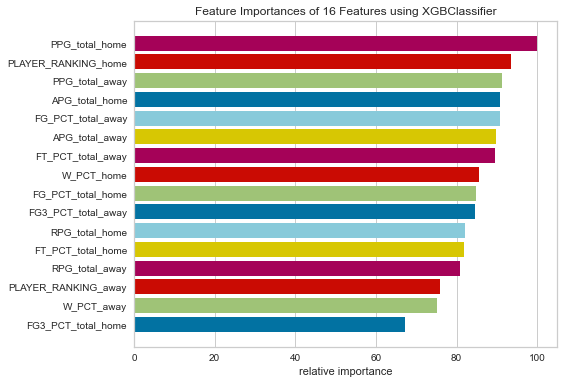

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({'scale_pos_weight': 10}): 0.58
              precision    recall  f1-score   support

           0       0.60      0.35      0.44       301
           1       0.58      0.79      0.67       337

    accuracy                           0.58       638
   macro avg       0.59      0.57      0.56       638
weighted avg       0.59      0.58      0.56       638



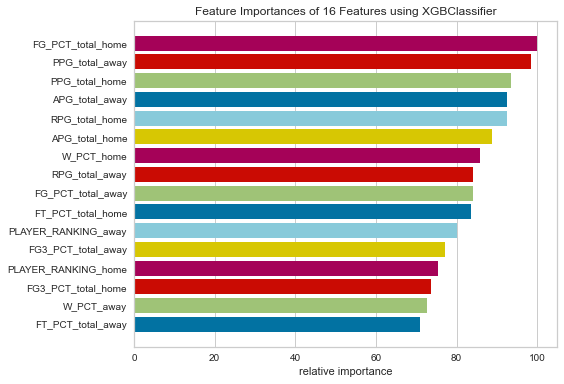

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({'scale_pos_weight': 13}): 0.59
              precision    recall  f1-score   support

           0       0.74      0.34      0.47       334
           1       0.55      0.87      0.67       304

    accuracy                           0.59       638
   macro avg       0.64      0.61      0.57       638
weighted avg       0.65      0.59      0.56       638



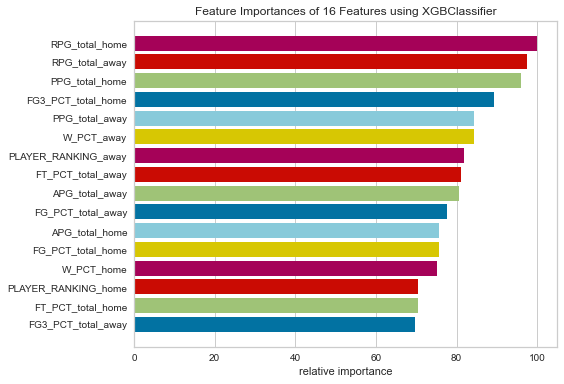

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({'scale_pos_weight': 5}): 0.60
              precision    recall  f1-score   support

           0       0.62      0.40      0.49       298
           1       0.60      0.78      0.68       339

    accuracy                           0.60       637
   macro avg       0.61      0.59      0.58       637
weighted avg       0.61      0.60      0.59       637



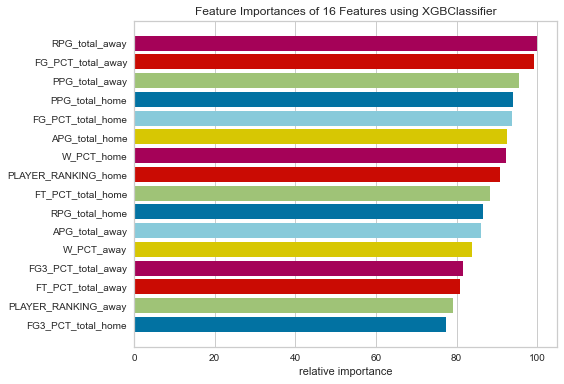

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({'scale_pos_weight': 14}): 0.59
              precision    recall  f1-score   support

           0       0.67      0.32      0.43       314
           1       0.56      0.85      0.67       323

    accuracy                           0.59       637
   macro avg       0.62      0.58      0.55       637
weighted avg       0.61      0.59      0.56       637



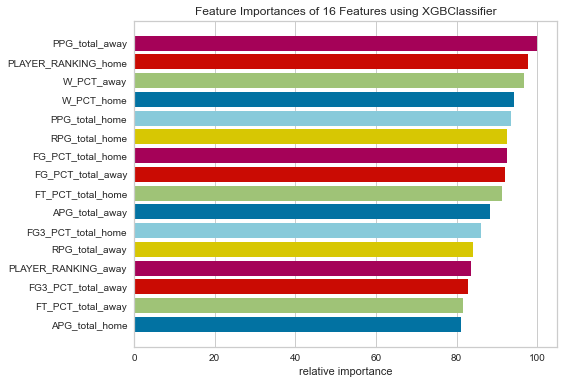

---------------------------------------------
Mean accuracy: 0.5962399669296221
Max accuracy: 0.6043956043956044
Min accuracy: 0.5846394984326019
i=20
AST:

Best XGBoost accuracy ({'scale_pos_weight': 1}): 0.65
              precision    recall  f1-score   support

           0       0.67      0.78      0.72       570
           1       0.60      0.46      0.52       405

    accuracy                           0.65       975
   macro avg       0.63      0.62      0.62       975
weighted avg       0.64      0.65      0.64       975



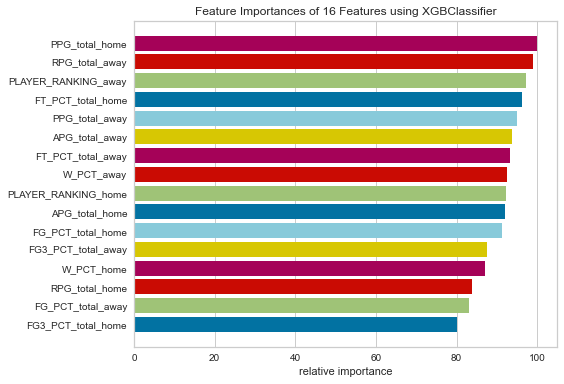

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({'scale_pos_weight': 1}): 0.66
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       592
           1       0.58      0.47      0.52       382

    accuracy                           0.66       974
   macro avg       0.64      0.63      0.63       974
weighted avg       0.65      0.66      0.65       974



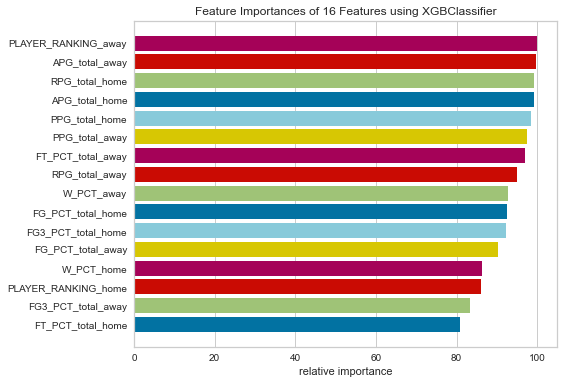

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.58
              precision    recall  f1-score   support

           0       0.58      1.00      0.73       561
           1       0.00      0.00      0.00       413

    accuracy                           0.58       974
   macro avg       0.29      0.50      0.37       974
weighted avg       0.33      0.58      0.42       974



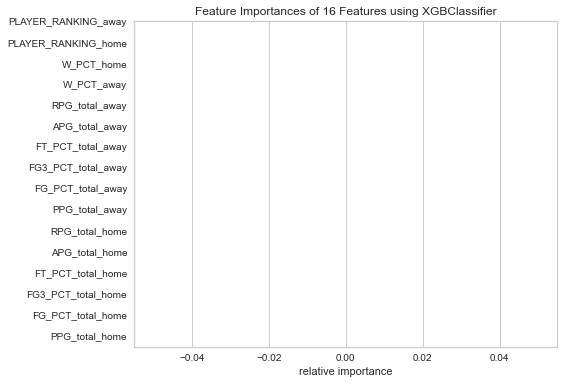

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({'scale_pos_weight': 5}): 0.60
              precision    recall  f1-score   support

           0       0.73      0.57      0.64       596
           1       0.49      0.66      0.57       378

    accuracy                           0.60       974
   macro avg       0.61      0.61      0.60       974
weighted avg       0.64      0.60      0.61       974



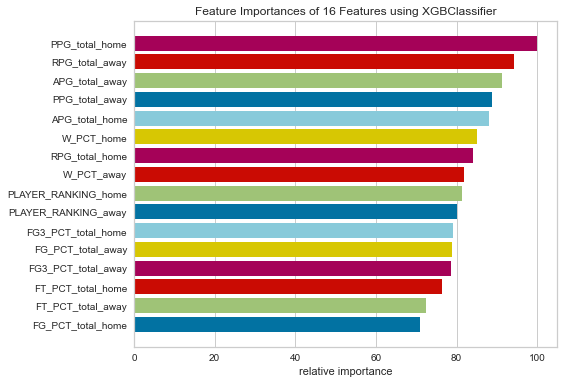

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({'scale_pos_weight': 2}): 0.66
              precision    recall  f1-score   support

           0       0.70      0.73      0.72       564
           1       0.61      0.56      0.58       410

    accuracy                           0.66       974
   macro avg       0.65      0.65      0.65       974
weighted avg       0.66      0.66      0.66       974



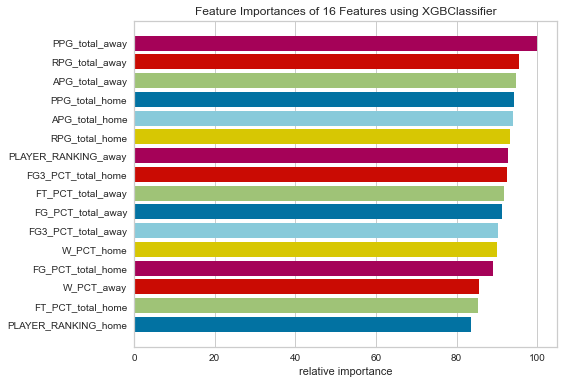

---------------------------------------------
Mean accuracy: 0.6217540672879482
Max accuracy: 0.6611909650924025
Min accuracy: 0.5759753593429158
i=25
REB:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.59
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       498
           1       0.00      0.00      0.00       342

    accuracy                           0.59       840
   macro avg       0.30      0.50      0.37       840
weighted avg       0.35      0.59      0.44       840



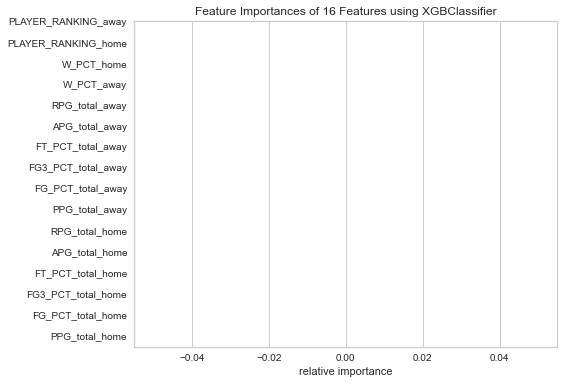

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.56
              precision    recall  f1-score   support

           0       0.56      1.00      0.72       471
           1       0.00      0.00      0.00       369

    accuracy                           0.56       840
   macro avg       0.28      0.50      0.36       840
weighted avg       0.31      0.56      0.40       840



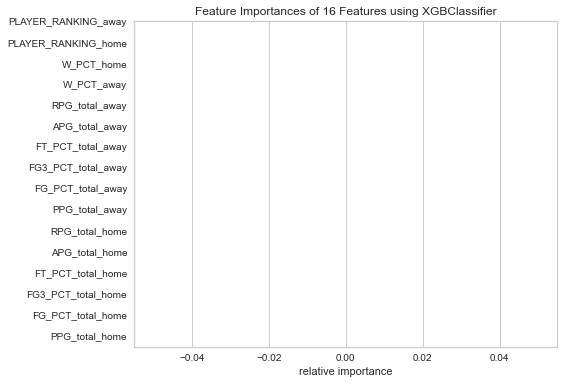

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({'scale_pos_weight': 2}): 0.64
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       473
           1       0.59      0.58      0.59       366

    accuracy                           0.64       839
   macro avg       0.64      0.63      0.63       839
weighted avg       0.64      0.64      0.64       839



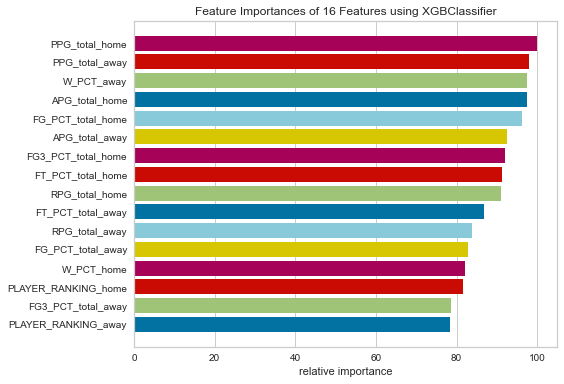

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({'scale_pos_weight': 7}): 0.59
              precision    recall  f1-score   support

           0       0.76      0.48      0.59       516
           1       0.48      0.75      0.58       323

    accuracy                           0.59       839
   macro avg       0.62      0.62      0.59       839
weighted avg       0.65      0.59      0.59       839



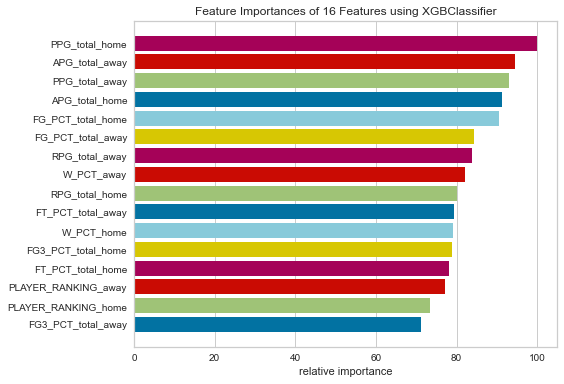

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.55
              precision    recall  f1-score   support

           0       0.55      1.00      0.71       465
           1       0.00      0.00      0.00       374

    accuracy                           0.55       839
   macro avg       0.28      0.50      0.36       839
weighted avg       0.31      0.55      0.40       839



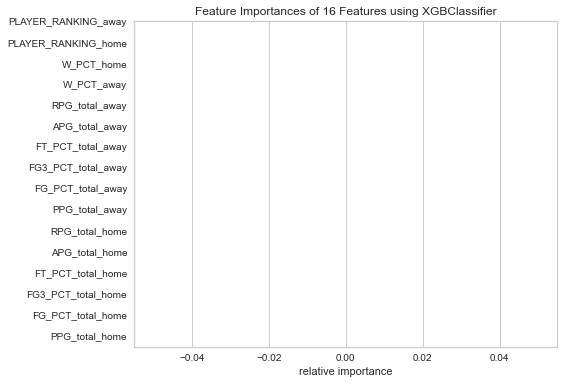

---------------------------------------------
Mean accuracy: 0.5953058487995913
Max accuracy: 0.6412395709177592
Min accuracy: 0.5607142857142857


In [36]:
# Control the balance of positive and negative weights, useful for unbalanced classes. 
# A typical value to consider: sum(negative instances) / sum(positive instances).

print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'scale_pos_weight' : [*range(0,30)],
})